In [1]:
from datasets import DatasetDict, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    T5Tokenizer,
    T5ForConditionalGeneration,
    T5Config,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    pipeline,
)
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
import numpy as np
import time
import gc
import GPUtil
import evaluate
from numba import cuda
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import wandb
import os
import pickle
import optuna
from typing import Dict, Union, Optional, Tuple, List, Any
import pandas as pd
import string
from tqdm import tqdm

2023-11-28 11:28:06.368271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 11:28:06.368323: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 11:28:06.368352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Random seed for reproducibility
RANDOM_SEED = 42

# Default parameters for T5 model fine-tuning
PER_DEVICE_TRAIN_BATCH_SIZE = 64
PER_DEVICE_EVAL_BATCH_SIZE = 128
LEARNING_RATE = 3e-4
NUM_TRAIN_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 2
NUM_BEAMS = 4

# Include BLEURT score in evaluation
INCLUDE_BLEURT = True

# Setting the DEVICE to cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set path for profane word list
PROFANE_WORD_PATH = "../data/raw/en.txt"

# Set path for raw dataset dictionary
RAW_DATASET_PATH = "../data/processed/raw_dataset.pkl"
AUG_DATASET_ALL_FILTERS_PATH = "../data/processed/aug_datasets_all_filters"
AUG_DATASET_NO_TOXICITY_FILTER_PATH = "../data/processed/aug_datasets_no_toxicity_filter"
AUG_DATASET_NO_SIMILARITY_FILTER_PATH = "../data/processed/aug_datasets_no_similarity_filter"
AUG_DATASET_NO_ACCEPTABILITY_FILTER_PATH = "../data/processed/aug_datasets_no_acceptability_filter"

# Set path for txt file containing best model checkpoints
BEST_MODEL_CHECKPOINT_PATH = "../models/best_model_checkpoints.txt"

# Set path to save evaluation outputs to
VAL_PREDS_PATH = "../results/val_preds.csv"
VAL_METRICS_PATH = "../results/val_metrics.csv"
TEST_PREDS_PATH = "../results/test_preds.csv"
TEST_METRICS_PATH = "../results/test_metrics.csv"

# Set maximum length for input and output
MAX_INPUT_LENGTH = 64
MAX_OUTPUT_LENGTH = 64

In [3]:
# Load tokenizers and models
tokenizer_t5_small = T5Tokenizer.from_pretrained("t5-small")
model_t5_small = T5ForConditionalGeneration.from_pretrained("t5-small").to(DEVICE)
tokenizer_toxicity = RobertaTokenizer.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier")
model_toxicity = RobertaForSequenceClassification.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier").to(DEVICE)
tokenizer_acceptability = AutoTokenizer.from_pretrained("iproskurina/tda-bert-en-cola")
model_acceptability = AutoModelForSequenceClassification.from_pretrained("iproskurina/tda-bert-en-cola").to(DEVICE)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassifi

In [4]:
# Load datasets
raw_datasets = DatasetDict.load_from_disk(RAW_DATASET_PATH)
aug_datasets_all_filters = DatasetDict.load_from_disk(AUG_DATASET_ALL_FILTERS_PATH)
aug_datasets_no_acceptability_filter = DatasetDict.load_from_disk(AUG_DATASET_NO_ACCEPTABILITY_FILTER_PATH)
aug_datasets_no_similarity_filter = DatasetDict.load_from_disk(AUG_DATASET_NO_SIMILARITY_FILTER_PATH)
aug_datasets_no_toxicity_filter = DatasetDict.load_from_disk(AUG_DATASET_NO_TOXICITY_FILTER_PATH)

In [5]:
# Load df_val_preds and df_val_metrics
df_val_preds = pd.read_csv(VAL_PREDS_PATH)
df_val_metrics = pd.read_csv(VAL_METRICS_PATH)

In [6]:
# Get model checkpoints
def get_model_checkpoints():
    with open(BEST_MODEL_CHECKPOINT_PATH, "r") as f:
        best_model_checkpoints = f.readlines()

    best_model_checkpoints_dict = {}
    for line in best_model_checkpoints:
        model_name, checkpoint_path = line.split(": ")
        best_model_checkpoints_dict[model_name] = checkpoint_path.strip()

    return best_model_checkpoints_dict

model_checkpoints = get_model_checkpoints()
model_checkpoints

{'t5_small_unidir': '../models/t5_small_unidir/checkpoint-840',
 't5_small_bidir_noshuf': '../models/t5_small_bidir_noshuf/checkpoint-2352',
 't5_small_bidir_shuf': '../models/t5_small_bidir_shuf/checkpoint-3024',
 't5_small_aug_all': '../models/t5_small_aug_all/checkpoint-2592',
 't5_small_aug_noaccept': '../models/t5_small_aug_noaccept/checkpoint-1620',
 't5_small_aug_nosim': '../models/t5_small_aug_nosim/checkpoint-2592',
 't5_small_aug_notox': '../models/t5_small_aug_notox/checkpoint-1944',
 't5_small_bidir_aug_nosim': '../models/t5_small_bidir_aug_nosim/checkpoint-1944'}

# Functions

## Debugging

In [7]:
def measure_time(func, *args, **kwargs):
    """
    Calculates the time it takes to run a function.
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Function {func.__name__} took {elapsed_time:.2f} seconds to run.")
    return result

def get_gpu_memory():
    """
    Gets the GPU memory information.
    """
    gpus = GPUtil.getGPUs()
    gpu = gpus[0]
    print(f"Total GPU memory: {gpu.memoryTotal}MB")
    print(f"Free GPU memory: {gpu.memoryFree}MB")
    print(f"Used GPU memory: {gpu.memoryUsed}MB")
    return gpu.memoryUsed

def force_clear_GPU_memory():
    """
    Force clears the GPU memory.
    """
    cuda.select_device(0)
    cuda.close()

def cleanup():
    """
    Cleans up the GPU memory.
    """
    gc.collect()
    torch.cuda.empty_cache()

## Baseline Models

In [8]:
# Baseline model functions
def baseline_detoxifier(text_list, profane_word_path=PROFANE_WORD_PATH):
    """
    Returns a detoxified version of the text by replacing toxic terms with blanks

    Args:
        text_list (list): list of strings to be detoxified
        toxic_list (list): list of toxic terms to be removed from text_list

    Returns:
        detoxified_text_list (list): list of detoxified strings
    """
    # Load list of profane words
    profane_words = []
    with open(profane_word_path, "r") as f:
        for line in f:
            profane_words.append(line.strip())

    # Detoxify text
    y_pred_delete = []
    for text in text_list:
        for term in profane_words:
            text = text.replace(term, "")
        y_pred_delete.append(text)

    return y_pred_delete

def bart_detoxifier(text_list):
    """
    Returns a detoxified version of the text using BART

    Args:
        text_list (list): list of strings to be detoxified

    Returns:
        detoxified_text_list (list): list of detoxified strings
    """
    pipe_bart = pipeline("text2text-generation", model="s-nlp/bart-base-detox", device=DEVICE)
    y_pred_bart = pipe_bart(text_list, max_length=MAX_OUTPUT_LENGTH, truncation=True)
    y_pred_bart = [x["generated_text"] for x in y_pred_bart]
    
    return y_pred_bart

## Evaluation

In [9]:
# Initialize model variables
model_bleurt = None
model_bertscore = None
model_sacrebleu = None

def calc_sacrebleu(refs, preds):
    """
    Calculates the SacreBLEU score.

    Args:
        refs (list): List of reference sentences
        preds (list): List of predicted sentences
    
    Returns:
        results (float): SacreBLEU score
    """
    global model_sacrebleu

    if model_sacrebleu is None:
        model_sacrebleu = evaluate.load("sacrebleu")

    results = model_sacrebleu.compute(predictions=preds, references=refs)["score"]
    results = results/100

    return results

def calc_bert_score(
    refs, preds, model_type="microsoft/deberta-large-mnli", output_mean=True
    ):
    """
    Calculates BERT score per line. Note: https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0 lists the best performing models
    Args:
        refs (list): List of reference sentences.
        y_pred (list): List of predicted sentences.
        model_type (str): Type of BERT model to use.
        output_mean (bool): Whether to output the mean of the scores.

    Returns:
        list of precision, recall, f1 scores.

    """
    global model_bertscore

    if model_bertscore is None:
        model_bertscore = evaluate.load("bertscore")
        
    results = model_bertscore.compute(predictions=preds, references=refs, model_type=model_type)
    precision = np.array(results["precision"])
    recall = np.array(results["recall"])
    f1 = np.array(results["f1"])
    
    if output_mean:
        precision = precision.mean()
        recall = recall.mean()
        f1 = f1.mean()

    return precision, recall, f1

def calc_bleurt(refs, preds, checkpoint="BLEURT-20_D12", output_mean = True):
    """
    Calculates BLEURT score per line.

    Args:
        refs (list): List of reference sentences.
        preds (list): List of predicted sentences.
        output_type (str): Type of output to return. Either 'numpy' or 'list'.

    Returns:
        list/array of BLEURT scores.
    """
    global model_bleurt

    if model_bleurt is None:
        model_bleurt = evaluate.load("bleurt", module_type="metric", checkpoint=checkpoint)

    results = np.array(model_bleurt.compute(predictions=preds, references=refs)["scores"])

    if output_mean:
        results = results.mean()

    return results

def calc_tox_acceptability(
    data,
    tokenizer,
    model,
    output_score=True,
    output_mean=True):
    """
    Calculates toxicity and acceptability scores for a given dataset.

    Args:
        data = list of strings to be evaluated
        tokenizer = tokenizer for the model
        model = model to be used for evaluation
        output_score = whether to output the score or the label
        output_mean = whether to output the mean of the scores or the scores for each sentence
    
    Returns:
        array of toxicity and acceptability scores.
    """  
    inputs = tokenizer(data, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs)["logits"]
        if output_score:
            result = torch.nn.functional.softmax(logits, dim=1)[:, 1]
        else:
            result = logits.argmax(1).data
        result = result.cpu().numpy()

    if output_mean:
        result = result.mean()
        
    return result

def evaluate_metrics(
    refs,
    preds,
    tokenizer_toxicity=tokenizer_toxicity,
    model_toxicity=model_toxicity,
    tokenizer_acceptability=tokenizer_acceptability,
    model_acceptability=model_acceptability,
    to_neutral=True,
    weights={
        "BLEU": 0.2,
        "STA": 0.4,
        "Acceptability": 0.2,
        "BERT_Score": 0.2
    },
    include_bleurt=INCLUDE_BLEURT
):
    """
    Calculates and returns a dictionary of evaluation metrics

    Args:
        refs (list): list of strings (reference)
        preds (list): list of strings (predictions)
        tokenizer_toxicity (tokenizer): tokenizer for toxicity model
        model_toxicity (model): toxicity model
        tokenizer_acceptability (tokenizer): tokenizer for acceptability model
        model_acceptability (model): acceptability model
        to_neutral (bool): whether the goal is to transfer to neutral (True) or to toxic (False)
        weights (dict): dictionary of weights for each metric
        include_bleurt (bool): whether to include BLEURT score in the output

    Returns:
        results (dict): dictionary of evaluation metrics
    """
    # Calculate BLEU score
    bleu = calc_sacrebleu(refs, preds)

    # Calculate toxicity classification
    tox_pred = calc_tox_acceptability(preds, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)

    # Calculate style transfer accuracy as proportion of sentences that were correctly classified (as non-toxic / toxic)
    if to_neutral:
        sta_correct_label = 0
    else:
        sta_correct_label = 1

    sta_pred = (tox_pred == sta_correct_label).sum() / len(tox_pred)

    # Calculate acceptability scores
    acc_pred = calc_tox_acceptability(preds, tokenizer_acceptability, model_acceptability)

    # Calculate similarity score
    bert_score_f1 = calc_bert_score(refs, preds, model_type="distilbert-base-uncased")[2]

    # Calculate BLEURT score if include_bleurt is True
    bleurt = None
    if include_bleurt:
        bleurt = calc_bleurt(refs, preds)

    # Calculate composite score
    composite_score = weights["BLEU"] * bleu + weights["STA"] * sta_pred + weights["Acceptability"] * acc_pred + weights["BERT_Score"] * bert_score_f1

    # Return a dictionary of metrics
    results = {
        "BLEU": bleu,
        "STA": sta_pred,
        "FLU": acc_pred,
        "SEM": bert_score_f1,
        "J": composite_score,
    }
    if include_bleurt:
        results["BLEURT"] = bleurt
        
    return results

In [10]:
def add_preds_to_df(model_name, preds, raw_datasets=raw_datasets, use_validation=True, load_csv=True, replace_existing=True):
    """
    Add model predictions to a pandas dataframe

    Args:
    - model_name: name of the model
    - preds: list of predictions
    - test_data: whether the data is test data or validation data (True for test data, False for validation data)
    - load_csv: whether to load the existing csv file. If False, a new dataframe will be created.
    - replace_existing: whether to replace an existing column if it already exists

    Returns:
    - updated pandas dataframe
    """

    # Set save path
    if use_validation:
        save_path = VAL_PREDS_PATH
        source = raw_datasets["validation"]["source"]
        target = raw_datasets["validation"]["target"]
    else:
        save_path = TEST_PREDS_PATH
        source = raw_datasets["test"]["source"]
        target = raw_datasets["test"]["target"]

    if load_csv:
        df = pd.read_csv(save_path)
    else:
        df = pd.DataFrame({
                "source": source,
                "target": target,
            })
    
    # If replace existing, remove the existing column with the same model name
    if f"{model_name}_preds" in df.columns and replace_existing:
        df = df.drop(columns=[f"{model_name}_preds"])
    
    df[f"{model_name}_preds"] = preds
    df.to_csv(save_path, index=False)

    return df

def add_metric_cols_to_preds(preds_col_name, use_validation=True, replace_existing=True):
    """
    Add metric columns to the dataframe

    Args:
    - preds_col_name: name of the column containing the predictions
    - use_validation: whether to use validation data or test data

    Returns:
    - updated dataframe
    """
    # Set save path
    if use_validation:
        save_path = VAL_PREDS_PATH
    else:
        save_path = TEST_PREDS_PATH

    # Load CSV
    df = pd.read_csv(save_path)

    # Dynamically create column names
    model_name = preds_col_name.split("_")[0]
    bleu_col_name = f"{model_name}_BLEU"
    bleurt_col_name = f"{model_name}_BLEURT"
    sta_col_name = f"{model_name}_STA"
    flu_col_name = f"{model_name}_FLU"
    sem_col_name = f"{model_name}_SEM"

    # If replace existing, remove the existing columns
    if bleu_col_name in df.columns and replace_existing:
        df = df.drop(columns=[bleu_col_name])
    if bleurt_col_name in df.columns and replace_existing:
        df = df.drop(columns=[bleurt_col_name])
    if sta_col_name in df.columns and replace_existing:
        df = df.drop(columns=[sta_col_name])
    if flu_col_name in df.columns and replace_existing:
        df = df.drop(columns=[flu_col_name])
    if sem_col_name in df.columns and replace_existing:
        df = df.drop(columns=[sem_col_name])

    # Calculate metrics
    df[bleu_col_name] = df.apply(lambda row: calc_sacrebleu([row["target"]], [row[preds_col_name]]), axis=1)
    df[bleurt_col_name] = calc_bleurt(df["target"], df[preds_col_name], output_mean=False)
    df[sta_col_name] = 1 - calc_tox_acceptability(df[preds_col_name].tolist(), tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
    df[flu_col_name] = calc_tox_acceptability(df[preds_col_name].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
    df[sem_col_name] = calc_bert_score(df["target"], df[preds_col_name], model_type="distilbert-base-uncased", output_mean=False)[2]

    df.to_csv(save_path, index=False)

    return df

# Helper function to add metrics to the dataframe
def add_metrics_to_df(model_name, metrics, use_validation=True, load_csv=True, replace_existing=True):
    """
    Add model metrics to a pandas dataframe
    
    Args:
    - df: pandas dataframe to add metrics to
    - model_name: name of the model
    - metrics: dictionary of evaluation metrics
    - test_data: whether the data is test data or validation data (True for test data, False for validation data)
    - load_csv: whether to load the existing csv file. If False, a new dataframe will be created.
    - replace_existing: whether to replace an existing column if it already exists
    
    Returns:
    - updated pandas dataframe
    """

    # Set save path
    if use_validation:
        save_path = VAL_METRICS_PATH
    else:
        save_path = TEST_METRICS_PATH
        
    # Load the existing dataframe if it exists
    if load_csv:
        df = pd.read_csv(save_path)
    else:
        df = pd.DataFrame(columns=["Model", "BLEURT", "BLEU", "STA", "FLU", "SEM", "J"])

    # If replace existing, remove the existing row with the same model name
    if model_name in df["Model"].values and replace_existing:
        df = df[df["Model"] != model_name]

    # Add the new row to the dataframe
    model_metrics_df = pd.DataFrame({
        "Model": [model_name],
        "BLEURT": [metrics["BLEURT"]],
        "BLEU": [metrics["BLEU"]],
        "STA": [metrics["STA"]],
        "FLU": [metrics["FLU"]],
        "SEM": [metrics["SEM"]],
        "J": [metrics["J"]]
    })

    # Save the dataframe to a csv file
    df = pd.concat([df, model_metrics_df], ignore_index=True)
    df.to_csv(save_path, index=False)
    
    return df


## Trainer Object Setup

In [11]:
def add_prefix(datasetdict, prefix="to_neutral: "):
    """Adds a prefix to the source sequence in the dataset."""
    datasetdict_copy = datasetdict.copy()
    datasetdict_copy["train"] = datasetdict_copy["train"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict_copy["validation"] = datasetdict_copy["validation"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict_copy["test"] = datasetdict_copy["test"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict_copy = DatasetDict(datasetdict_copy)
    return datasetdict_copy

def create_bidirectional_dataset(datasets, shuffle=True):
    """
    Creates a bi-directional dataset from the original dataset.

    Args:
        datasets (DatasetDict): DatasetDict object containing the original dataset.
        shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
        extended_datasets (DatasetDict): DatasetDict object containing the bi-directional dataset.
    """

    def bidirectional_extension(dataset):
        new_data = {
            "source": [],
            "target": []
        }
        for src, tgt in zip(dataset['source'], dataset['target']):
            new_data['source'].extend([f'to_neutral: {src}', f'to_toxic: {tgt}'])
            new_data['target'].extend([tgt, src])
        return new_data

    extended_train_data = bidirectional_extension(datasets["train"])
    extended_validation_data = bidirectional_extension(datasets["validation"])
    extended_test_data = bidirectional_extension(datasets["test"])

    extended_datasets = DatasetDict({
        "train": Dataset.from_dict(extended_train_data),
        "validation": Dataset.from_dict(extended_validation_data),
        "test": Dataset.from_dict(extended_test_data)
    })

    if shuffle:
        extended_datasets["train"] = extended_datasets["train"].shuffle(seed=RANDOM_SEED)
        
    return extended_datasets

def preprocess_dataset(dataset, tokenizer):
    """Preprocesses a dataset using a tokenizer."""
    def preprocess_function(examples, tokenizer):
        """Preprocess function for T5."""
        model_inputs = tokenizer(
            examples["source"],
            text_target=examples["target"],
            max_length=MAX_INPUT_LENGTH,
            truncation=True,
        )
        return model_inputs

    return dataset.map(
        preprocess_function,
        fn_kwargs={'tokenizer': tokenizer},
        batched=True,
        remove_columns=["source", "target"],
    )

def post_process(preds, refs, tokenizer):
    """
    Post-process function for T5.

    Args:
        preds (list): list of predicted sequences
        refs (list): list of reference sequences
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding

    Returns:
        decoded_preds (list): list of decoded predicted sequences
        decoded_refs (list): list of decoded reference sequences
    """
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    refs = np.where(refs != -100, refs, tokenizer.pad_token_id)
    decoded_refs = tokenizer.batch_decode(refs, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_refs = [ref.strip() for ref in decoded_refs]

    return decoded_preds, decoded_refs

def post_process_preds(preds, tokenizer):
    """
    Post-process function for T5 (only for predictions)

    Args:
        preds (list): list of predicted sequences
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding

    Returns:
        decoded_preds (list): list of decoded predicted sequences
    """
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds]

    return decoded_preds

def compute_metrics(eval_preds, tokenizer):
    """
    Function to calculate the metrics for trainer.evaluate().

    Args:
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding the predictions
        eval_preds (tuple): Tuple containing the predictions and references

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # Post-process the predictions and references
    decoded_preds, decoded_refs = post_process(preds, refs, tokenizer)
    
    # Evaluate metrics
    return evaluate_metrics(
        decoded_refs,
        decoded_preds,
        tokenizer_toxicity=tokenizer_toxicity,
        model_toxicity=model_toxicity,
        tokenizer_acceptability=tokenizer_acceptability,
        model_acceptability=model_acceptability,
        include_bleurt=INCLUDE_BLEURT
    )

def compute_metrics_bd(eval_preds, tokenizer, bd_dataset, shuffled_data=False):
    """
    Function to calculate the metrics for trainer.evaluate().
    This function is for the bi-directional model.
    
    Args:
        eval_preds (tuple): Tuple containing the predictions and references
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding the predictions
        shuffled_data (bool): Whether the data is shuffled or not
        bd_dataset (DatasetDict): Bidirectional dataset to use for testing created using create_bidirectional_datasets
                                  For example, raw_datasets_bd["validation"] or raw_datasets_bd["test"]

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # Post-process the predictions and references
    decoded_preds, decoded_refs = post_process(preds, refs, tokenizer)
    
    # If shuffled data is false, have to_neutral_preds and to_neutral_refs just be predictions and refs with even indices
    if not shuffled_data:
        to_neutral_preds = decoded_preds[::2]
        to_neutral_refs = decoded_refs[::2]
    # Otherwise, get the indices to use when splitting predictions and refs to to_neutral and to_toxic
    else:
        # Get the indices to use when splitting predictions and refs to to_neutral and to_toxic
        to_neutral_idx = [i for i, input_sentence in enumerate(bd_dataset['source']) if input_sentence.startswith("to_neutral")]

        # Retrieve based on the indices
        to_neutral_preds = [decoded_preds[i] for i in to_neutral_idx]
        to_neutral_refs = [decoded_refs[i] for i in to_neutral_idx]
    
    # Evaluate metrics for to_neutral
    to_neutral_metrics = evaluate_metrics(
        to_neutral_refs,
        to_neutral_preds,
        include_bleurt=INCLUDE_BLEURT
    )

    # Return dictionary of to_neutral metrics
    return to_neutral_metrics

def setup_trainer(output_dir_name,
                train_dataset,
                eval_dataset,
                compute_metrics,
                model_checkpoint="t5-small",
                per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
                per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
                learning_rate=LEARNING_RATE,
                num_train_epochs=NUM_TRAIN_EPOCHS,
                max_length=MAX_OUTPUT_LENGTH,
                num_beams=NUM_BEAMS,
                early_stopping_patience=EARLY_STOPPING_PATIENCE,
                report_to="wandb",
                ):
    """
    Set up a Seq2SeqTrainer object for training a T5 model.

    Default parameters based on this: https://github.com/google-research/text-to-text-transfer-transformer/blob/main/t5/models/hf_model.py#L55

    Args:
        output_dir_name (str): What to name the model in the output directory.
        train_dataset (Dataset): Training dataset.
        eval_dataset (Dataset): Evaluation dataset.
        compute_metrics (function): Function to compute metrics. Change this to compute_metrics_bd if using a bi-directional model.
        model_checkpoint (str): Model checkpoint to use.
        per_device_train_batch_size (int): Batch size for training.
        per_device_eval_batch_size (int): Batch size for evaluation.
        learning_rate (float): Learning rate.
        num_train_epochs (int): Number of training epochs.
        max_length (int): Maximum length of the output sequence.
        num_beams (int): Number of beams for beam search.
        early_stopping_patience (int): Number of epochs to wait before early stopping.
        report_to (str): Where to report results to. Either "wandb" or "none".

    Returns:
        Seq2SeqTrainer: Trainer object for training the T5 model.
    """
    
    # Instantiate model and tokenizer
    model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)
    tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

    # Define the data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer, model, return_tensors="pt", padding=True)

    # Define generation config
    generation_config = GenerationConfig(
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        eos_token_id=model.config.eos_token_id,
        bos_token_id=model.config.bos_token_id,
        pad_token_id=model.config.pad_token_id,
        decoder_start_token_id=model.config.pad_token_id
        )

    # Save the generation config
    gen_config_path = f"../models/{output_dir_name}/generation_config"
    generation_config.save_pretrained(gen_config_path)

    # Define the training arguments
    args = Seq2SeqTrainingArguments(
        output_dir=f'../models/{output_dir_name}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        learning_rate=learning_rate, 
        predict_with_generate=True,
        generation_config=gen_config_path,
        fp16=True,
        report_to=report_to,
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="Overall",
        greater_is_better=True,
        generation_max_length=max_length,
    )
   
    # Instantiate the trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]
    )

    return trainer

def training_pipeline(model_name, project_name="t5-detox", model_checkpoint="t5-small", use_validation=True, raw_datasets=raw_datasets, bidirectional=False, shuffle=False, do_train=True):
    """
    Pipeline for training a T5 model. Saves the best model checkpoint to a txt file. Can also be used for evaluating a model (use test set instead of validation set).

    Args:
        model_name (str): Name of the model to name the output directory and wandb run.
        project_name (str): Name of the wandb project.
        model_checkpoint (str): Model checkpoint to use.
        use_validation (bool): Whether to use the validation set or not.
        raw_datasets (DatasetDict): DatasetDict object containing the original dataset.
        bidirectional (bool): Whether to use a bi-directional model or not.
        shuffle (bool): Whether to shuffle the dataset or not.
        do_train (bool): Whether to train the model or not. Keep as false if you just want to evaluate the model.

    Returns:
        trainer (Seq2SeqTrainer): Trainer object for training the T5 model.
    """
    
    # Preprocess dataset (add prefixes / make bidirectional)
    if bidirectional and do_train:
        raw_datasets = create_bidirectional_dataset(raw_datasets, shuffle=shuffle)
    else:
        raw_datasets = add_prefix(raw_datasets)

    # Tokenize dataset
    tokenized_datasets = preprocess_dataset(raw_datasets, tokenizer_t5_small)

    # Define compute_metrics function depending on bidirectional or not
    if bidirectional and do_train and use_validation:
        bd_dataset = raw_datasets["validation"]
    elif bidirectional and do_train and not use_validation:
        bd_dataset = raw_datasets["test"]
    else:
        bd_dataset = None

    compute_metrics_fn = partial(compute_metrics_bd, bd_dataset=bd_dataset, shuffled_data=shuffle) if bd_dataset else compute_metrics

    # Setup trainer
    trainer = setup_trainer(
        output_dir_name=model_name,
        model_checkpoint=model_checkpoint,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"] if use_validation else tokenized_datasets["test"],
        compute_metrics=compute_metrics_fn
    )

    # Train the model
    if do_train:
        # Initialize wandb
        wandb.init(project=project_name, name=model_name)
        trainer.train()
        wandb.finish()

        # Get the best checkpoint path for the model
        checkpoint_path = trainer.state.best_model_checkpoint

        # Save the checkpoint path for the best model
        with open(BEST_MODEL_CHECKPOINT_PATH, "a") as file:
            file.write(f"{model_name}: {checkpoint_path}\n")

    return trainer, tokenized_datasets

## Negative Lexically Constrained Decoding

In [12]:
def get_bad_words_list(dataset, tokenizer=tokenizer_toxicity, model=model_toxicity, num_layers=3, top_k=3):
    """
    Gets the top k bad words for each sentence in the dataset based on attention scores from the toxicity classifier.

    Args:
        dataset (list): List of sentences.
        tokenizer (PreTrainedTokenizer): Tokenizer to use (toxicity classifier).
        model (PreTrainedModel): Model to use (toxicity classifier).
        num_layers (int): Number of top n layers in the model to use for attention-based bad word identification.
        top_k (int): Number of bad words to return.

    Returns:
        bad_words_list (list): List of lists of bad words.
    """    
    bad_words_list = []

    for sentence in dataset:
        # Tokenize sentence
        inputs = tokenizer(sentence, return_tensors="pt").to(DEVICE)
        input_ids = inputs["input_ids"]

        # Get attention scores
        attention = model(input_ids, output_attentions=True)['attentions']

        # Get the last num_layers layer attention scores and average them
        attention = torch.stack(attention[-num_layers:]).mean(0)

        # Average across each head
        attention = attention.mean(1)

        # Sum each row to get the attention score for each token
        attention = attention.mean(1)

        # Exclude separator tokens and punctuation
        token_list = input_ids.squeeze().tolist()
        punctuation_ids = {tokenizer.convert_tokens_to_ids(token) for token in string.punctuation}
        exclude_ids = set([tokenizer.bos_token_id, tokenizer.eos_token_id]) | punctuation_ids

        valid_indices = [i for i, token_id in enumerate(token_list) if token_id not in exclude_ids]

        # Filter out the valid indices from the attention scores
        valid_attention = attention.squeeze()[valid_indices]

        # Get the indices of the top k tokens with the highest attention scores among valid tokens
        top_indices = valid_attention.topk(top_k).indices.tolist()
        top_token_indices = [valid_indices[i] for i in top_indices]

        # Decode the tokens
        bad_words = [tokenizer.decode(token_list[index]).strip() for index in top_token_indices]

        bad_words_list.append(bad_words)

    return bad_words_list

def generate_pred_nlcd(raw_sentence, model, tokenizer, tokenizer_prefix_space, num_layers=3, top_k=3):
    """
    Generate predictions for a single raw sentence using the NLCD (Negative Lexically Constrained Decoding) method.

    Args:
        raw_sentence (str): The raw sentence to generate predictions for.
        model (T5ForConditionalGeneration): The T5 model for generation.
        tokenizer (T5Tokenizer): The tokenizer for tokenizing the input.
        tokenizer_prefix_space (T5Tokenizer): The tokenizer for tokenizing the input with prefix space.
        num_layers (int): The number of layers to consider for generating bad words.
        top_k (int): The number of top bad words to consider.

    Returns:
        str: The generated prediction for the input sentence.
    """

    # Tokenize inputs
    inputs = tokenizer([raw_sentence], return_tensors="pt")
    input_ids = inputs["input_ids"]

    def get_tokens_as_list(word_list):
        "Converts a sequence of words into a list of tokens"
        tokens_list = []
        for word in word_list:
            tokenized_word = tokenizer_prefix_space([word], add_special_tokens=False).input_ids[0]
            tokens_list.append(tokenized_word)
        return tokens_list

    # Get toxic words
    bad_words = get_bad_words_list([raw_sentence], tokenizer_toxicity, model_toxicity, num_layers=num_layers, top_k=top_k)[0]
    bad_words_ids = get_tokens_as_list(word_list=bad_words)

    # Generate text while enforcing the bad words to not appear
    encoded_preds = model.generate(
        input_ids=input_ids,
        bad_words_ids=bad_words_ids,
        max_length=MAX_OUTPUT_LENGTH,
        num_beams=NUM_BEAMS,
        early_stopping=True,
        eos_token_id=model.config.eos_token_id,
        bos_token_id=model.config.bos_token_id,
        pad_token_id=model.config.pad_token_id,
        decoder_start_token_id=model.config.pad_token_id
    )
    
    # Decode the generated text
    decoded_preds = tokenizer.batch_decode(encoded_preds, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds][0]

    return decoded_preds

def generate_preds_nlcd(raw_sentences,
                        model_checkpoint,
                        num_layers=3,
                        top_k=3):
    """
    Generate predictions for a list of raw sentences using the NLCD (Negative Lexically Constrained Decoding) method.

    Args:
        raw_sentences (list): A list of raw sentences to generate predictions for.
        model_checkpoint (str): The model checkpoint to use for generation.        
        num_layers (int): The number of layers to 
        top_k (int): The number of top bad words to consider.

    Returns:
        list: A list of generated predictions for the input sentences.
    """

    # Load model and tokenizers based on the checkpoint
    model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)
    tokenizer = T5Tokenizer.from_pretrained(model_checkpoint, add_prefix_space=False)
    tokenizer_prefix_space = T5Tokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

    # Create a list to store the predictions
    preds = []

    # Iterate through each raw sentence
    for raw_sentence in tqdm(raw_sentences):
        # Add prefix to the raw sentence
        raw_sentence = f"to_neutral: {raw_sentence}"

        # Generate predictions with NLCD
        decoded_preds = generate_pred_nlcd(raw_sentence, model, tokenizer, tokenizer_prefix_space, num_layers, top_k)

        # Append the predictions to the list of predictions
        preds.append(decoded_preds)

    return preds

def nlcd_hyperparameter_optimization(raw_datasets=raw_datasets,
                                     model_checkpoint=model_checkpoints["t5_small_unidir"],
                                     bw_top_k_list=[1, 2, 3, 4, 5],
                                     num_bw_layers_list=[1, 2, 3, 4, 5],
                                     default_num_layers=3,
                                     include_bleurt=True,
                                     num_validation_rows=200):
    """
    Perform hyperparameter optimization for NLCD by trying different values for num_bw_layers and bw_top_k.

    Args:
    - raw_datasets: The raw datasets dictionary object containing the source and target sentences.
    - model_checkpoint: The checkpoint of the T5 model to use.
    - bw_top_k_list: A list of values to try for bw_top_k.
    - num_bw_layers_list: A list of values to try for num_bw_layers.
    - default_num_layers: The default number of layers to use for bw_top_k.
    - include_bleurt: Whether to include BLEURT in the evaluation metrics.

    - num_validation_rows: Number of rows to use from raw_datasets["validation"].

    Returns:
    - metrics_df: A DataFrame containing the evaluation metrics for different hyperparameter combinations.
    """

    # Filter the validation dataset to the first num_validation_rows rows
    if num_validation_rows is not None:
        validation_source = raw_datasets["validation"]["source"][:num_validation_rows]
        validation_target = raw_datasets["validation"]["target"][:num_validation_rows]
    else:
        validation_source = raw_datasets["validation"]["source"]
        validation_target = raw_datasets["validation"]["target"]

    # Initialize an empty DataFrame
    metrics_df = pd.DataFrame(columns=["num_layers", "top_k", "BLEU", "STA", "FLU", "SEM", "J"])
    if include_bleurt:
        metrics_df["BLEURT"] = None  # Initialize the BLEURT column if include_bleurt is True

    best_J_score = -1
    best_num_layers = None
    best_top_k = None

    # Iterate through bw_top_k while keeping default_num_layers constant
    if len(bw_top_k_list) == 1:
        best_top_k = bw_top_k_list[0]
    else:
        for bw_top_k in bw_top_k_list:
            print(f"Number of Attention Layers: {default_num_layers}, Top K: {bw_top_k}")
            t5_ud_nlcd_preds = generate_preds_nlcd(raw_sentences=validation_source,
                                                    model_checkpoint=model_checkpoint,
                                                    num_layers=default_num_layers,
                                                    top_k=bw_top_k)
            t5_ud_nlcd_metrics = evaluate_metrics(validation_target, t5_ud_nlcd_preds, include_bleurt=include_bleurt)
            print(t5_ud_nlcd_metrics)
            
            J_score = t5_ud_nlcd_metrics["J"]

            row_dict = {
                "num_layers": [default_num_layers],
                "top_k": [bw_top_k],
                "BLEU": [t5_ud_nlcd_metrics["BLEU"]],
                "STA": [t5_ud_nlcd_metrics["STA"]],
                "FLU": [t5_ud_nlcd_metrics["FLU"]],
                "SEM": [t5_ud_nlcd_metrics["SEM"]],
                "J": [J_score]
            }

            if include_bleurt:
                row_dict["BLEURT"] = [t5_ud_nlcd_metrics["BLEURT"]]  # Add BLEURT score if include_bleurt is True

            metrics_df = pd.concat([metrics_df, pd.DataFrame(row_dict)], ignore_index=True)

            if J_score > best_J_score:
                best_J_score = J_score
                best_top_k = bw_top_k

    # Try different values for num_bw_layers while keeping best_top_k constant (the best top_k from the previous step)
    for num_bw_layers in num_bw_layers_list:
        print(f"Number of Attention Layers: {num_bw_layers}, Top K: {best_top_k}")
        t5_ud_nlcd_preds = generate_preds_nlcd(raw_sentences=validation_source,
                                                model_checkpoint=model_checkpoint,
                                                num_layers=num_bw_layers,
                                                top_k=best_top_k)
        t5_ud_nlcd_metrics = evaluate_metrics(validation_target, t5_ud_nlcd_preds, include_bleurt=include_bleurt)
        print(t5_ud_nlcd_metrics)
        
        J_score = t5_ud_nlcd_metrics["J"]

        row_dict = {
            "num_layers": [num_bw_layers],
            "top_k": [best_top_k],
            "BLEU": [t5_ud_nlcd_metrics["BLEU"]],
            "STA": [t5_ud_nlcd_metrics["STA"]],
            "FLU": [t5_ud_nlcd_metrics["FLU"]],
            "SEM": [t5_ud_nlcd_metrics["SEM"]],
            "J": [J_score]
        }

        if include_bleurt:
            row_dict["BLEURT"] = [t5_ud_nlcd_metrics["BLEURT"]]  # Add BLEURT score if include_bleurt is True

        metrics_df = pd.concat([metrics_df, pd.DataFrame(row_dict)], ignore_index=True)

        if J_score > best_J_score:
            best_J_score = J_score
            best_num_layers = num_bw_layers

    return metrics_df, best_num_layers, best_top_k

## T5 Evaluation Helper Functions

In [13]:
def get_t5_preds_metrics(model_checkpoint,
                         raw_datasets=raw_datasets,
                         bidirectional=False,
                         shuffle=False,
                         use_validation=True,
                         do_train=False,
                         tokenizer=tokenizer_t5_small
                         ):
    """
    Returns the predictions and metrics for a fine-tuned T5 model.
    """
    
    # Setup training pipeline
    trainer, trainer_tokenized_ds = training_pipeline(
        model_name="n/a",
        project_name="n/a",
        model_checkpoint=model_checkpoint,
        use_validation=use_validation,
        raw_datasets=raw_datasets,
        bidirectional=bidirectional,
        shuffle=shuffle,
        do_train=do_train
    )

    # Get raw predictions
    if use_validation:
        trainer_preds_raw = trainer.predict(trainer_tokenized_ds["validation"])
    else:
        trainer_preds_raw = trainer.predict(trainer_tokenized_ds["test"])

    # Get encoded predictions and metrics
    trainer_preds_encoded, trainer_metrics = trainer_preds_raw.predictions, trainer_preds_raw.metrics

    # Post-process predictions
    if isinstance(trainer_preds_encoded, tuple):
        trainer_preds_encoded = trainer_preds_encoded[0]

    trainer_preds_decoded = tokenizer.batch_decode(trainer_preds_encoded, skip_special_tokens=True)
    trainer_preds_decoded = [pred.strip() for pred in trainer_preds_decoded]

    # Return trainer metrics in the same format as evaluate_metrics
    trainer_metrics = {
        "BLEU": trainer_metrics["test_BLEU"],
        "BLEURT": trainer_metrics["test_BLEURT"],
        "STA": trainer_metrics["test_STA"],
        "FLU": trainer_metrics["test_FLU"],
        "SEM": trainer_metrics["test_SEM"],
        "J": trainer_metrics["test_J"]
    }
        
    # Return predictions and metrics
    return trainer_preds_decoded, trainer_metrics

def compare_outputs(
    df,
    cols_to_compare = ["source", "target", "BART_preds", "T5-UD-DA_preds", "T5-UD-DA-MinLoss_preds"],
    bad_words_cols = ['source', 'T5-UD_preds'],
    num_examples = 5,
    num_layers = 8,
    top_k = 3,
    print_toxic_words = True,
    random_state = RANDOM_SEED,
):
    """"""
    # Randomly sample the filtered dataset
    df_sample = df.sample(n=num_examples, random_state=random_state)

    # Get toxic words for in bad_words_col_1, bad_words_col_2, and bad_words_col_3
    if print_toxic_words and bad_words_cols is not None:
        ## Initialize a dictionary of bad words
        bad_words = {}

        ## Get bad words for each model
        for bad_words_col in bad_words_cols:
            bad_words[bad_words_col] = get_bad_words_list(df_sample[bad_words_col], num_layers=num_layers, top_k=top_k)

    # Print every line for each col in cols_to_compare, and the bad words for each col in bad_words_cols
    for i in range(num_examples):
        if cols_to_compare is not None:
            for col in cols_to_compare:
                # Format the column name to remove _preds and capitalise first letter
                if col in ['source', 'target']:
                    col_name = col.capitalize()
                elif col.endswith("_preds"):
                    col_name = col[:-len("_preds")]
                print(f"{col_name}: {df_sample[col].iloc[i]}")
        if bad_words_cols is not None:
            for bad_words_col in bad_words_cols:
                # Format the column name to remove _preds and capitalise first letter
                if bad_words_col in ['source', 'target']:
                    bad_words_col_name = bad_words_col.capitalize()
                elif bad_words_col.endswith("preds"):
                    bad_words_col_name = bad_words_col[:-len("_preds")]
                print(f"'Toxic' words in {bad_words_col_name}: {bad_words[bad_words_col][i]}")
        print()

# Evaluation Using Validation Set

## Source Text

In [88]:
source_val_metrics = evaluate_metrics(raw_datasets["validation"]["target"], raw_datasets["validation"]["source"])
df_val_metrics = add_metrics_to_df("Source", source_val_metrics, use_validation=True, load_csv=True)

## Human Reference

In [84]:
ref_val_metrics = evaluate_metrics(raw_datasets["validation"]["target"], raw_datasets["validation"]["target"])
df_val_metrics = add_metrics_to_df("Human Reference", ref_val_metrics, use_validation=True, load_csv=True)

## Baseline: DELETE

In [22]:
delete_val_preds = baseline_detoxifier(raw_datasets["validation"]["source"])
df_val_preds = add_preds_to_df("DELETE", delete_val_preds, use_validation=True, load_csv=False)

delete_val_metrics = evaluate_metrics(raw_datasets["validation"]["target"], delete_val_preds)
df_val_metrics = add_metrics_to_df("DELETE", delete_val_metrics, use_validation=True, load_csv=False)

/tmp/ipykernel_15355/1601193926.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, model_metrics_df], ignore_index=True)


## Baseline: BART

In [24]:
bart_val_preds = bart_detoxifier(raw_datasets["validation"]["source"])
df_val_preds = add_preds_to_df("BART", bart_val_preds, use_validation=True, load_csv=True)
df_val_preds = add_metric_cols_to_preds("BART_preds", use_validation=True)

bart_val_metrics = evaluate_metrics(raw_datasets["validation"]["target"], bart_val_preds)
df_val_metrics = add_metrics_to_df("BART", bart_val_metrics, use_validation=True, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## T5-Small (Unidirectional)

In [63]:
t5_ud_val_preds, t5_ud_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_unidir"],
    use_validation=True)

df_val_preds = add_preds_to_df("T5-UD", t5_ud_val_preds, use_validation=True, load_csv=True)
df_val_preds = add_metric_cols_to_preds("T5-UD_preds", use_validation=True)

df_val_metrics = add_metrics_to_df("T5-UD", t5_ud_val_metrics, use_validation=True, load_csv=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Based on this example, the largest differences between BART and T5-Small-UD are in relation to BLEURT.

Comparison of BLEURT

In [24]:
# Filter the dataset to rows where BART has better BLEURT score than T5-UD
df_BLEURT_BART_vs_T5_UD = df_val_preds[(df_val_preds["BART_BLEURT"] >= df_val_preds["T5-UD_BLEURT"] * 1.2) & (df_val_preds["BART_BLEURT"] != df_val_preds["T5-UD_BLEURT"])]

# Compmare outputs
compare_outputs(
    df=df_BLEURT_BART_vs_T5_UD,
    cols_to_compare=['source', 'target', 'BART_preds', 'T5-UD_preds'],
    bad_words_cols=None,
)

Source: Most people understand trumps comments for what they were the whining of a sore loser.
Target: Most people understand trumps comments were result of his defeat.
BART: Most people understand trumps comments for what they were.
T5-UD: Most people understand trumps comments for what they were the bad of a loser.

Source: But then the incredibly stupid can continue to ignore the obvious.
Target: But then those who don't know anything can continue to not pay attention to the obvious.
BART: But then they can continue to ignore the obvious.
T5-UD: But then the incredibly bad can continue to ignore the obvious.

Source: Rt ima agree with you on that his shit is so bland and shallow
Target: I agree with you that his performance is bland and shallow
BART: I agree with you that his performance is bland and shallow
T5-UD: Rt ima agree with you on that his thing is so bland and shallow

Source: No bitch i miss being 80 you on the other hand are still a " teen
Target: No girl i miss being 80

Comparison of STA

In [173]:
# Filter the dataset to rows where BART is better than T5-Small-UD in terms of STA
df_STA_BART_vs_T5_UD = df_val_preds[(df_val_preds["BART_STA"] == 1) & (df_val_preds["T5-UD_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_BART_vs_T5_UD,
    cols_to_compare=['source', 'target', 'BART_preds', 'T5-UD_preds'],
    bad_words_cols=['source', 'T5-UD_preds'],
)

Source: You have cold dead hands.
Target: You have cold hands.
BART: You have cold hands
T5-UD: You have cold dead hands
'Toxic' words in Source: ['You', 'dead', 'hands']
'Toxic' words in T5-UD: ['You', 'dead', 'hands']

Source: All canadians are paying for what the left wing voted in, many canadians were not so stupid.
Target: All canadians are paying for what the left wing voted in, many canadians had common sense.
BART: All Canadians are paying for what the left wing voted in, many canadians were not so naive
T5-UD: All canadians are paying for what the left wing voted in, many canadians were not so stupid.
'Toxic' words in Source: ['stupid', 'were', 'All']
'Toxic' words in T5-UD: ['stupid', 'were', 'All']

Source: This is just an asinine statement in my mind of someone trying to save his own ass.
Target: This is just a statement in my mind of someone trying to protect themselves.
BART: This is just a statement in my mind of someone trying to save themselves.
T5-UD: This is just an 

## T5-Small (Bidirectional)

In [36]:
model_checkpoints

{'t5_small_unidir': '../models/t5_small_unidir/checkpoint-840',
 't5_small_bidir_noshuf': '../models/t5_small_bidir_noshuf/checkpoint-2352',
 't5_small_bidir_shuf': '../models/t5_small_bidir_shuf/checkpoint-3024',
 't5_small_aug_all': '../models/t5_small_aug_all/checkpoint-2592',
 't5_small_aug_noaccept': '../models/t5_small_aug_noaccept/checkpoint-1620',
 't5_small_aug_nosim': '../models/t5_small_aug_nosim/checkpoint-2592',
 't5_small_aug_notox': '../models/t5_small_aug_notox/checkpoint-1944'}

In [37]:
# Get predictions and metrics
t5_bd_val_preds, t5_bd_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_bidir_shuf"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-BD", t5_bd_val_preds, use_validation=True, load_csv=True)

# Add per-row metrics to dataframe
df_val_preds = add_metric_cols_to_preds("T5-BD_preds", use_validation=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-BD", t5_bd_val_metrics, use_validation=True, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
df_val_metrics

,Model,BLEURT,BLEU,STA,FLU,SEM,J
0,DELETE,-0.227430,0.529101,0.659681,0.478651,0.911821,0.647787
1,BART,0.466564,0.701595,0.917854,0.718025,0.945139,0.840093
2,T5-UD,0.206119,0.606150,0.902766,0.707668,0.925923,0.809055
3,T5-BD,0.217048,0.611682,0.912825,0.711991,0.926827,0.815230


Comparison of BLEURT vs. T5-Small-UD

In [81]:
# Filter the dataset to rows where BLEURT of T5-Small-BD exceeds T5-Small-UD by 20% and are not identical
df_BLEURT_T5_BD_vs_T5_UD = df_val_preds[(df_val_preds["T5-BD_BLEURT"] >= df_val_preds["T5-UD_BLEURT"] * 1.2) & (df_val_preds["T5-BD_BLEURT"] != df_val_preds["T5-UD_BLEURT"])]

compare_outputs(
    df=df_BLEURT_T5_BD_vs_T5_UD,
    cols_to_compare=['source','target','T5-UD_preds','T5-BD_preds'],
    bad_words_cols=None,
)


Source: Lol fuck im ever doing that formsprings, perfect exampleas why not to do it
Target: Lol im ever doing that formsprings, perfect exampleas why not to do it
T5-UD: I'm ever doing that formsprings, perfect exampleas why not to do it
T5-BD: Lol im ever doing that formsprings, perfect exampleas why not to do it

Source: Hey, respect to op for sticking around and not giving a shit
Target: Hey, respect to op for sticking around and not caring about it.
T5-UD: Hey, respect to op for sticking around and not giving a thing
T5-BD: Hey, respect to op for sticking around and not caring

Source: Im having the hardest time accepting that shit man!!! irefuse to believe this shit
Target: I'm having the hardest time accepting that man, I refuse to believe this.
T5-UD: Im having the hardest time accepting that man!!! irefuse to believe this man
T5-BD: I am having the hardest time accepting that man!!! irefuse to believe this

Source: Icantdateyou if ur hairy af - _ - fucks noo! lol
Target: I cant

Comparison of STA vs. T5-Small-UD

In [174]:
# Filter the dataset to rows where BART is better than T5-Small-UD in terms of STA
df_STA_T5_BD_vs_T5_UD = df_val_preds[(df_val_preds["T5-BD_STA"] == 1) & (df_val_preds["T5-UD_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_BD_vs_T5_UD,
    cols_to_compare=['source','target','T5-UD_preds','T5-BD_preds'],
    bad_words_cols=['source','T5-UD_preds'],
    num_examples=5,
    num_layers=8,
    top_k=2,
)


Source: You already burned down to a crisp in fort mac by your own stupidity, already.
Target: You already lost in fort mac.
T5-UD: You already burned down to a crisp in fort mac by your own ignorance, already.
T5-BD: You already burned down to a crisp in fort mac by yourself, already.
'Toxic' words in Source: ['stupidity', 'burned']
'Toxic' words in T5-UD: ['burned', 'You']

Source: True conservatives, that are not white racists, will have to find a new home.
Target: Correct
T5-UD: True conservatives, that are not white, will have to find a new home.
T5-BD: True conservatives will have to find a new home.
'Toxic' words in Source: ['white', 'racists']
'Toxic' words in T5-UD: ['white', 'True']

Source: So you would love to see the commys win over a duly elected democratic president, man you are sick
Target: So you would love to see the communist win over a duly elected democratic president
T5-UD: So you would love to see the commys win over a duly elected democratic president, man you a

## T5-Small (Unidirectional, Data Augmentation)

In [23]:
model_checkpoints

{'t5_small_unidir': '../models/t5_small_unidir/checkpoint-840',
 't5_small_bidir_noshuf': '../models/t5_small_bidir_noshuf/checkpoint-2352',
 't5_small_bidir_shuf': '../models/t5_small_bidir_shuf/checkpoint-3024',
 't5_small_aug_all': '../models/t5_small_aug_all/checkpoint-2592',
 't5_small_aug_noaccept': '../models/t5_small_aug_noaccept/checkpoint-1620',
 't5_small_aug_nosim': '../models/t5_small_aug_nosim/checkpoint-2592',
 't5_small_aug_notox': '../models/t5_small_aug_notox/checkpoint-1944'}

### All Filters

In [43]:
# Get predictions and metrics
t5_ud_da_val_preds, t5_ud_da_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_all"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA", t5_ud_da_val_preds, use_validation=True, load_csv=True)

# Add row metrics to dataframe
df_val_preds = add_metric_cols_to_preds("T5-UD-DA_preds", use_validation=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-DA", t5_ud_da_val_metrics, use_validation=True, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### All Filters (Minimum Loss)

In [13]:
# Get predictions and metrics
t5_ud_da_minloss_val_preds, t5_ud_da_minloss_val_metrics = get_t5_preds_metrics(
    model_checkpoint="../models/t5_small_aug_all/checkpoint-972",
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA-MinLoss", t5_ud_da_minloss_val_preds, use_validation=True, load_csv=True)

# Add row metrics to dataframe
df_val_preds = add_metric_cols_to_preds("T5-UD-DA-MinLoss_preds", use_validation=True)

# Add metrics to dataframe
# df_val_metrics = add_metrics_to_df("T5-Small-Aug-All-MinLoss", t5_ud_da_minloss_val_metrics, use_validation=True, load_csv=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Compare Outputs of All Filter vs. All Filter (Minimum Loss)

In [56]:
# Filter to rows where T5-UD-DA-MinLoss has STA == 0 and T5-UD-DA has STA == 1
df_STA_T5_UD_DA_MinLoss_vs_T5_UD_DA = df_val_preds[(df_val_preds["T5-UD-DA-MinLoss_STA"] == 0) & (df_val_preds["T5-UD-DA_STA"] == 1)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_UD_DA_MinLoss_vs_T5_UD_DA,
    cols_to_compare=['source','target','T5-UD-DA-MinLoss_preds', 'T5-UD-DA_preds'],
    bad_words_cols=['source','T5-UD-DA-MinLoss_preds'],
    random_state=42
)

Source: Bitch was so mad lmfao!! smh
Target: She was so mad!
T5-UD-DA-MinLoss: Bitch was so mad
T5-UD-DA: He was so mad.
'Toxic' words in Source: ['itch', 'B', 'was']
'Toxic' words in T5-UD-DA-MinLoss: ['itch', 'was', 'B']

Source: Pitiful choice scalia was a hypocrite!
Target: Scalia was a bad person
T5-UD-DA-MinLoss: Choice scalia was a hypocrite!
T5-UD-DA: Choice scalia was not a good person!
'Toxic' words in Source: ['sc', 'was', 'hypocr']
'Toxic' words in T5-UD-DA-MinLoss: ['was', 'sc', 'hypocr']

Source: He's a fucking street thug.
Target: He's a street gang member.
T5-UD-DA-MinLoss: He's a street thug
T5-UD-DA: He's a street guy.
'Toxic' words in Source: ['fucking', 'He', "'s"]
'Toxic' words in T5-UD-DA-MinLoss: ['He', 'thug', "'s"]

Source: Doosh doosh doosh doosh doosh fucking cock sucker queir bate ass wipe dont tell me what the fuck to write
Target: Don't tell me what to write.
T5-UD-DA-MinLoss: Doosh doosh doosh doosh cock sucker queir bate wipe dont tell me what to write
T

### No Toxicity Filter

In [106]:
# Get predictions and metrics
t5_ud_da_notox_val_preds, t5_ud_da_notox_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_notox"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA-NoTOX", t5_ud_da_notox_val_preds, use_validation=True, load_csv=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-DA-NoTOX", t5_ud_da_notox_val_metrics, use_validation=True, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### No Semantic Similarity Filter

In [14]:
# Get predictions and metrics
t5_ud_da_nosem_val_preds, t5_ud_da_nosem_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_nosim"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA-NoSEM", t5_ud_da_nosem_val_preds, use_validation=True, load_csv=True)
df_val_preds = add_metric_cols_to_preds("T5-UD-DA-NoSEM_preds", use_validation=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-DA-NoSEM", t5_ud_da_nosem_val_metrics, use_validation=True, load_csv=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### No Fluency Filter

In [108]:
# Get predictions and metrics
t5_ud_da_noflu_val_preds, t5_ud_da_noflu_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_noaccept"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA-NoFLU", t5_ud_da_noflu_val_preds, use_validation=True, load_csv=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-DA-NoFLU", t5_ud_da_noflu_val_metrics, use_validation=True, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
df_val_metrics

,Model,BLEURT,BLEU,STA,FLU,SEM,J
0,DELETE,-0.227430,0.529101,0.659681,0.478651,0.911821,0.647787
1,BART,0.466564,0.701595,0.917854,0.718025,0.945139,0.840093
2,T5-BD,0.217048,0.611682,0.912825,0.711991,0.926827,0.815230
3,T5-UD-DA,0.204206,0.593218,0.916178,0.714662,0.925547,0.813157
4,T5-UD-DA-NoTOX,0.208252,0.598625,0.892707,0.713698,0.925555,0.804659
5,T5-UD-DA-NoSEM,0.211811,0.591599,0.917854,0.719671,0.924972,0.814390
6,T5-UD-DA-NoFLU,0.192281,0.595025,0.903604,0.709992,0.925311,0.807508
7,T5-UD,0.206119,0.606150,0.902766,0.707668,0.925923,0.809055


## T5-Small (UD, NLCD)

Let's test that the functions works by filtering to cases where T5-UD_STA == 0. Theoretically NLCD should lead to the number of sentences with toxic words reducing

In [83]:
def nlcd_test():
    # Prefix the dataset
    prefixed_datasets = add_prefix(raw_datasets)

    # Get the raw sentences
    ## Get indices of rows where T5-UD has STA == 0
    t5_ud_sta_0_indices = df_val_preds[df_val_preds["T5-UD_STA"] == 0].index.tolist()

    ## Get predictions from T5-UD where STA == 0
    preds_no_nlcd = df_val_preds[df_val_preds["T5-UD_STA"] == 0]["T5-UD_preds"].tolist()

    ## Filter the raw sentences to just the ones where T5-UD has STA == 0
    input_sentences = [prefixed_datasets["validation"]["source"][i] for i in t5_ud_sta_0_indices]

    ## Get the references
    refs = [prefixed_datasets["validation"]["target"][i] for i in t5_ud_sta_0_indices]

    # Get toxic words for each sentence
    toxic_words_per_sentence = get_bad_words_list(input_sentences, tokenizer_toxicity, model_toxicity, num_layers=3, top_k=2)

    # Get predictions using NLCD
    preds_nlcd = generate_preds_nlcd(input_sentences, model_checkpoints["t5_small_unidir"], num_layers=3, top_k=2)

    # Count the number of cases where preds_no_nlcd contains a toxic word and calculate success rate
    num_toxic_words_no_nlcd = 0
    for i in range(len(preds_no_nlcd)):
        if any(toxic_word in preds_no_nlcd[i] for toxic_word in toxic_words_per_sentence[i]):
            num_toxic_words_no_nlcd += 1
    success_rate_no_nlcd = (len(preds_no_nlcd) - num_toxic_words_no_nlcd) / len(preds_no_nlcd)
    print(f"Count of sentences with toxic words in preds_no_nlcd: {num_toxic_words_no_nlcd}")
    print(f"Success rate of no_nlcd: {success_rate_no_nlcd}")

    # Count the number of cases where preds_nlcd contains a toxic word and calculate success rate
    num_toxic_words_nlcd = 0
    for i in range(len(preds_nlcd)):
        if any(toxic_word in preds_nlcd[i] for toxic_word in toxic_words_per_sentence[i]):
            num_toxic_words_nlcd += 1
    success_rate_nlcd = (len(preds_nlcd) - num_toxic_words_nlcd) / len(preds_nlcd)
    print(f"Count of sentences with toxic words in preds_nlcd: {num_toxic_words_nlcd}")
    print(f"Success rate of nlcd: {success_rate_nlcd}")

    # Print out the first 5 predictions
    for i in range(5):
        print()
        print(f"Source: {input_sentences[i]}")
        print(f"Target: {refs[i]}")
        print(f"Bad words: {toxic_words_per_sentence[i]}")
        print(f"Prediction without NLCD: {preds_no_nlcd[i]}")
        print(f"Prediction with NLCD: {preds_nlcd[i]}")

nlcd_test()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 116/116 [00:38<00:00,  3.02it/s]

Count of sentences with toxic words in preds_no_nlcd: 105
Success rate of no_nlcd: 0.09482758620689655
Count of sentences with toxic words in preds_nlcd: 32
Success rate of nlcd: 0.7241379310344828

Source: to_neutral: You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks.
Target: There are problems in Chicago that need to be dealt with as well as police brutality.
Bad words: ['blacks', 'killing']
Prediction without NLCD: You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks
Prediction with NLCD: You straighten out that chicago problem and then well tell our cops to stop shooting unarmed people.

Source: to_neutral: You have cold dead hands.
Target: You have cold hands.
Bad words: ['You', 'have']
Prediction without NLCD: You have cold dead hands
Prediction with NLCD: Your hands are not good.

Source: to_neutral: This is ridiculous and looks terrible if true.
Target: It's ridiculously terrible if t

Above we can see that bad words as identified by attention scores in the toxicity classifier have been removed

### Default Settings

Next we get predictions based on num_layers = 3 and top_k = 3

In [89]:
# Get predictions based on default hyperparameters
t5_ud_nlcd_val_preds = generate_preds_nlcd(raw_sentences=raw_datasets["validation"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_unidir"],
                                             num_layers=3,
                                             top_k=3)

t5_ud_nlcd_val_metrics = evaluate_metrics(refs=raw_datasets["validation"]["target"],
                                          preds=t5_ud_nlcd_val_preds,
                                          include_bleurt=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-NLCD", t5_ud_nlcd_val_preds, use_validation=True, load_csv=True, replace_existing=True)

# Calculate per-row metrics
df_val_preds = add_metric_cols_to_preds("T5-UD-NLCD_preds", use_validation=True, replace_existing=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-NLCD", t5_ud_nlcd_val_metrics, use_validation=True, load_csv=True, replace_existing=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1193/1193 [06:11<00:00,  3.21it/s]


In [92]:
df_val_metrics

,Model,BLEURT,BLEU,STA,FLU,SEM,J
0,DELETE,-0.227430,0.529101,0.659681,0.478651,0.911821,0.647787
1,BART,0.466564,0.701595,0.917854,0.718025,0.945139,0.840093
2,T5-BD,0.217048,0.611682,0.912825,0.711991,0.926827,0.815230
3,T5-UD-DA,0.204206,0.593218,0.916178,0.714662,0.925547,0.813157
4,T5-UD-DA-NoTOX,0.208252,0.598625,0.892707,0.713698,0.925555,0.804659
5,T5-UD-DA-NoSEM,0.211811,0.591599,0.917854,0.719671,0.924972,0.814390
6,T5-UD-DA-NoFLU,0.192281,0.595025,0.903604,0.709992,0.925311,0.807508
7,T5-UD,0.206119,0.606150,0.902766,0.707668,0.925923,0.809055
8,ref,0.989226,1.000000,0.953898,0.716085,1.000000,0.924776
9,T5-UD-NLCD,-0.046128,0.440937,0.960604,0.711287,0.892896,0.793266


Just using layers = 3 and top_k = 3 shows that STA increases significantly (in fact higher than ref) but at the cost of BLEURT, BLEU and SEM

In [91]:
# Filter to rows where T5-UD-NLCD has STA == 1 and T5-UD has STA == 0
df_STA_T5_UD_NLCD_vs_T5_UD = df_val_preds[(df_val_preds["T5-UD-NLCD_STA"] == 1) & (df_val_preds["T5-UD_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_UD_NLCD_vs_T5_UD,
    cols_to_compare=['source','target','T5-UD-NLCD_preds', 'T5-UD_preds'],
    bad_words_cols=['source', 'T5-UD_preds'],
)

Source: We get these ignorant losers pushed to the forefront because america has a majority of ignorant nonreaders, eric norstog
Target: We get these guys pushed to the forefront because America has a majority of non readers who are not knowledgeable. Eric Norstog
T5-UD-NLCD: We get these people pushed to the forefront because america has a majority of nonreaders, eric norstog
T5-UD: We get these people pushed to the forefront because america has a majority of ignorant nonreaders, eric norstog
'Toxic' words in Source: ['losers', 'ignorant', 'americ']
'Toxic' words in T5-UD: ['ignorant', 'americ', 'of']

Source: You have cold dead hands.
Target: You have cold hands.
T5-UD-NLCD: Your hands are not good.
T5-UD: You have cold dead hands
'Toxic' words in Source: ['You', 'dead', 'hands']
'Toxic' words in T5-UD: ['You', 'hands', 'dead']

Source: They should all be whipped and quartered!
Target: They should all be punished
T5-UD-NLCD: All of them should have been punished.
T5-UD: They should b

As seen above, the issue with nlcd using top k is that it picks up on words that aren't actually toxic. We may need to do some hyperparameter optimization

### Hyperparameter optimization

In [ ]:
metrics_df, best_num_layers, best_top_k = nlcd_hyperparameter_optimization(
    bw_top_k_list=[1, 2, 3, 4, 5],
    num_bw_layers_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    default_num_layers=3,
)

In [117]:
# Save metrics_df to csv
metrics_df.to_csv("../results/nlcd_ho_t5_ud.csv", index=False)

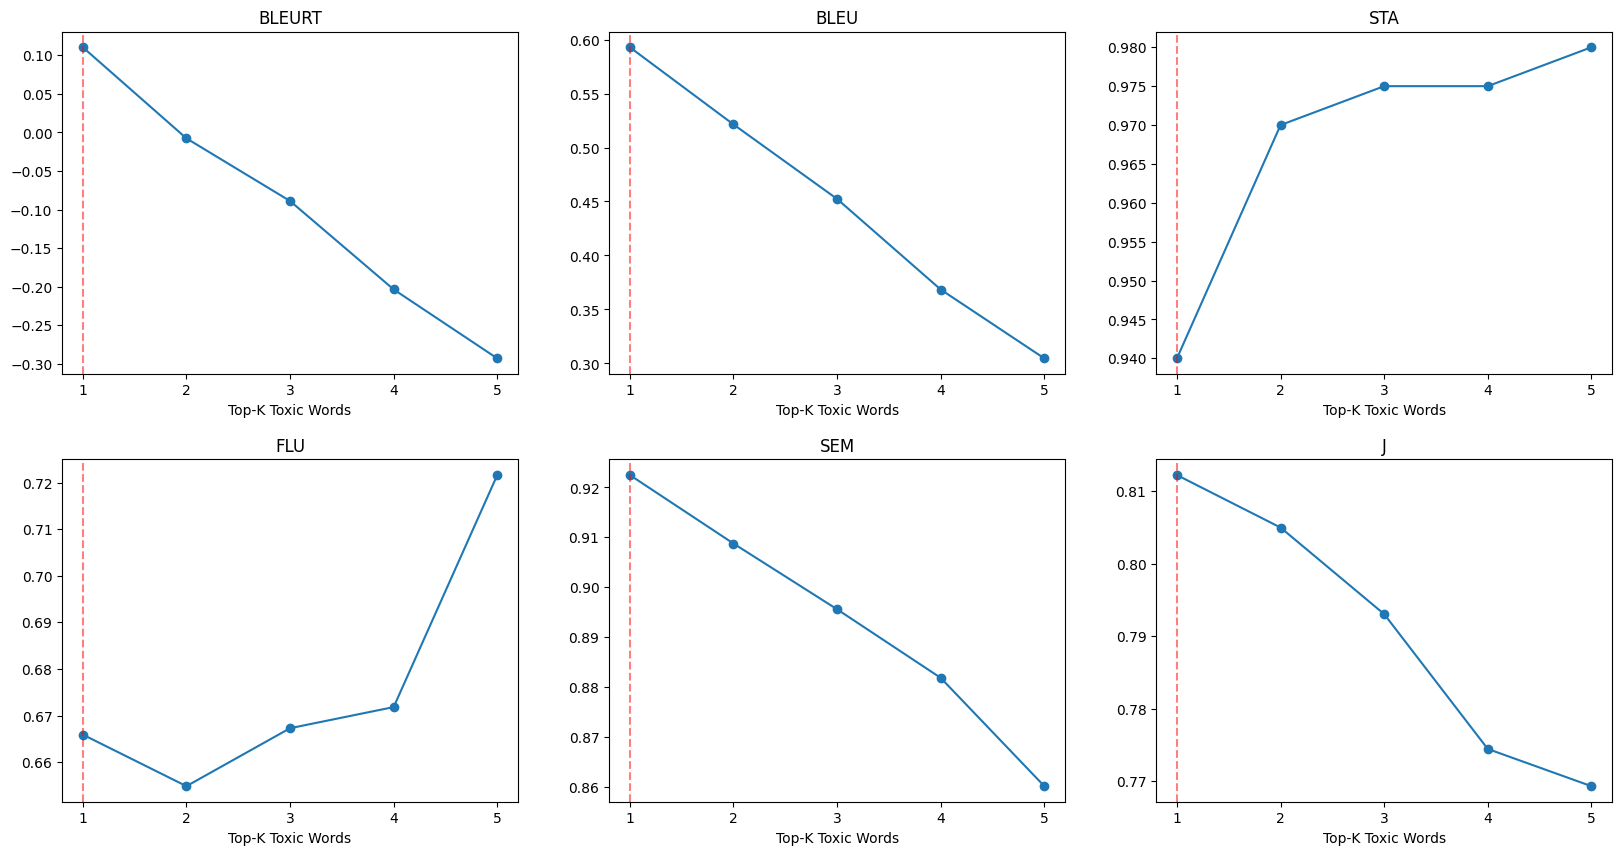

In [157]:
# From metrics_df, filter to index 0 to 4 (inclusive)
metrics_df_numlayers = metrics_df.iloc[0:5]
metrics_df_numlayers

# Plot the BLEURT, BLEU, STA, FLU, SEM, and J scores for different values of num_layers in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
axes[0].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["BLEURT"], marker="o")
axes[0].set_title("BLEURT")
axes[1].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["BLEU"], marker="o")
axes[1].set_title("BLEU")
axes[2].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["STA"], marker="o")
axes[2].set_title("STA")
axes[3].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["FLU"], marker="o")
axes[3].set_title("FLU")
axes[4].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["SEM"], marker="o")
axes[4].set_title("SEM")
axes[5].plot(metrics_df_numlayers["top_k"], metrics_df_numlayers["J"], marker="o")
axes[5].set_title("J")

for i in range(6):
    axes[i].set_xlabel("Top-K Toxic Words") # Set x-axis label
    axes[i].set_xticks(np.arange(1, 6, 1))  # Set xticks to be in intervals of 1
    axes[i].axvline(x=1, color="red", linestyle="--", alpha=0.5)    # Add a vertical line at x=1

# Add whitespace between horizontal subplots
plt.subplots_adjust(hspace=0.25)

plt.show()

# Export the figure
fig.savefig("../results/nlcd_top_k.png")

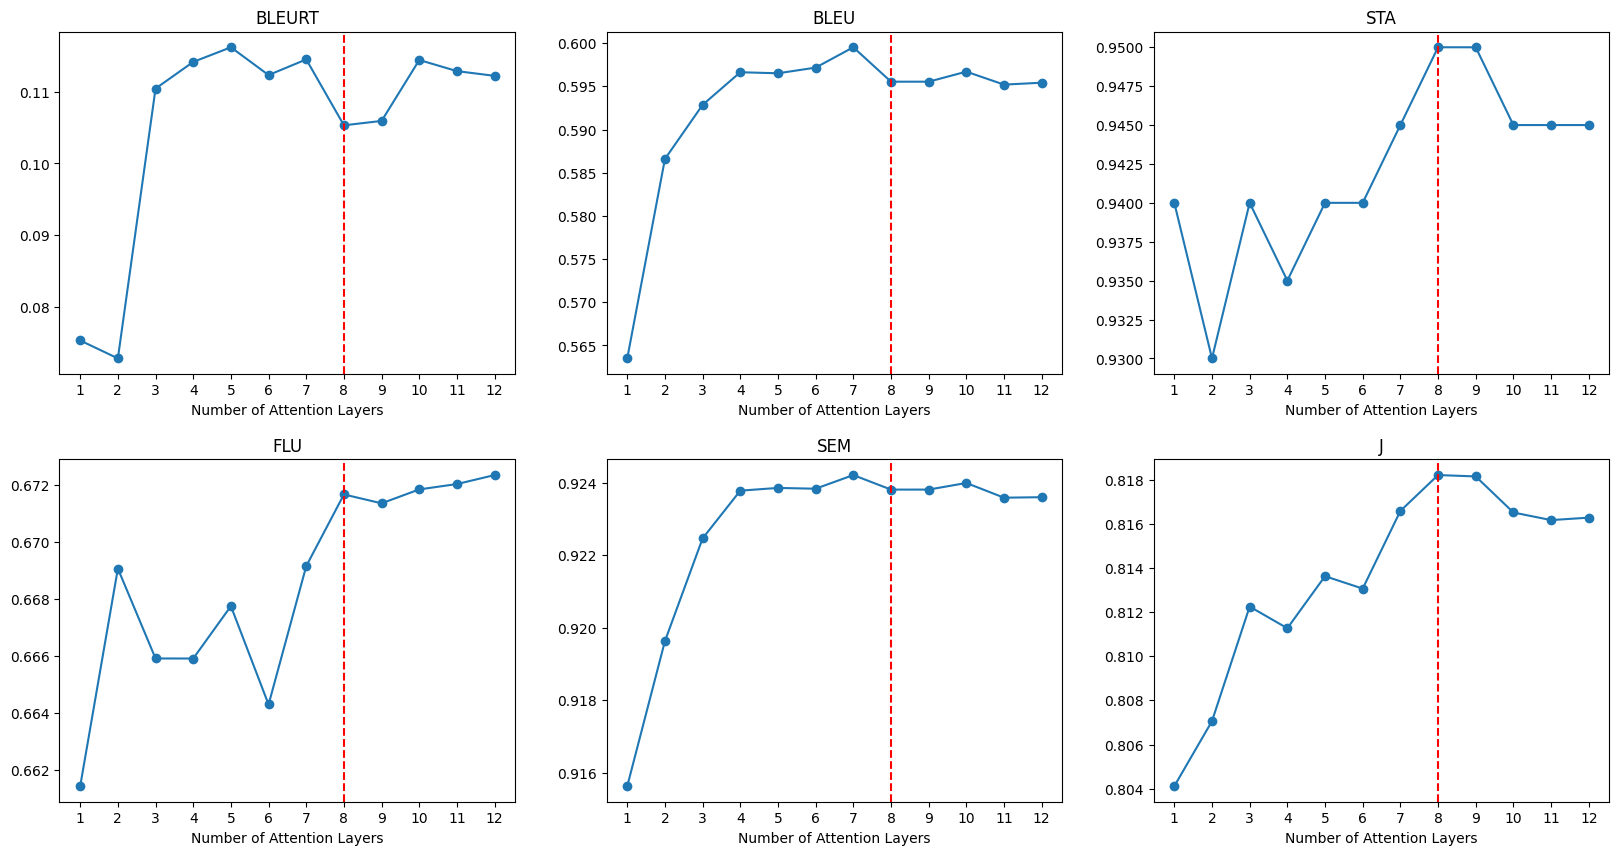

In [158]:
# From metrics_df, filter to index 5 to 16 (inclusive)
metrics_df_numlayers = metrics_df.iloc[5:17]
metrics_df_numlayers

# Plot the BLEURT, BLEU, STA, FLU, SEM, and J scores for different values of num_layers in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
axes[0].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["BLEURT"], marker="o")
axes[0].set_title("BLEURT")
axes[1].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["BLEU"], marker="o")
axes[1].set_title("BLEU")
axes[2].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["STA"], marker="o")
axes[2].set_title("STA")
axes[3].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["FLU"], marker="o")
axes[3].set_title("FLU")
axes[4].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["SEM"], marker="o")
axes[4].set_title("SEM")
axes[5].plot(metrics_df_numlayers["num_layers"], metrics_df_numlayers["J"], marker="o")
axes[5].set_title("J")

for i in range(6):
    axes[i].axvline(x=8, color="red", linestyle="dashed")
    axes[i].set_xlabel("Number of Attention Layers")
    axes[i].set_xticks(np.arange(1, 13, 1))

# Add whitespace between horizontal subplots
plt.subplots_adjust(hspace=0.25)

plt.show()

# Export the figure
fig.savefig("../results/nlcd_num_layers.png")

It appears that keeping top k as 1 is ideal. Increasing top k leads to improved STA but at the cost of other metrics. Increasing the number of layers also leads to better results, with the joint score maximized at 8 attention layers with top k of 1.

In [159]:
# Get predictions based on optimal hyperparameters
t5_ud_nlcd_ho_val_preds = generate_preds_nlcd(raw_sentences=raw_datasets["validation"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_unidir"],
                                             num_layers=8,
                                             top_k=1)

t5_ud_nlcd_ho_val_metrics = evaluate_metrics(refs=raw_datasets["validation"]["target"],
                                          preds=t5_ud_nlcd_ho_val_preds,
                                          include_bleurt=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-NLCD-HO", t5_ud_nlcd_ho_val_preds, use_validation=True, load_csv=True, replace_existing=True)

# Calculate per-row metrics
df_val_preds = add_metric_cols_to_preds("T5-UD-NLCD-HO_preds", use_validation=True, replace_existing=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-NLCD-HO", t5_ud_nlcd_ho_val_metrics, use_validation=True, load_csv=True, replace_existing=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1193/1193 [05:49<00:00,  3.41it/s]


In [162]:
# Filter to rows where T5-UD-NLCD has STA == 1 and T5-UD has STA == 0
df_STA_T5_UD_NLCD_HO_vs_T5_UD = df_val_preds[(df_val_preds["T5-UD-NLCD-HO_STA"] == 1) & (df_val_preds["T5-UD_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_UD_NLCD_HO_vs_T5_UD,
    cols_to_compare=['source','target','T5-UD_preds', 'T5-UD-NLCD-HO_preds'],
    bad_words_cols=['source', 'T5-UD_preds'],
    num_layers = 8,
    top_k = 1,
)

Source: So you would love to see the commys win over a duly elected democratic president, man you are sick
Target: So you would love to see the communist win over a duly elected democratic president
T5-UD: So you would love to see the commys win over a duly elected democratic president, man you are sick
T5-UD-NLCD-HO: So you would love to see the commys win over a duly elected democratic president.
'Toxic' words in Source: ['sick']
'Toxic' words in T5-UD: ['sick']

Source: People who use drugs are just weak minded.
Target: People who use drugs have no resistance to stress and depressions.
T5-UD: People who use drugs are just weak minded
T5-UD-NLCD-HO: People who use drugs are not good.
'Toxic' words in Source: ['minded']
'Toxic' words in T5-UD: ['weak']

Source: When are the liberals going to kill the gst?
Target: When are the liberals going to ruin the gst?
T5-UD: When are the liberals going to kill him?
T5-UD-NLCD-HO: When are the liberals going to destroy the gst
'Toxic' words in So

In [58]:
# Filter to rows where T5-UD has higher BLEURT than T5-UD-NLCD-HO by 20%
df_BLEURT_T5_UD_vs_T5_UD_NLCD_HO = df_val_preds[(df_val_preds["T5-UD_BLEURT"] >= df_val_preds["T5-UD-NLCD-HO_BLEURT"] * 1.2)]

# Compare outputs
compare_outputs(
    df=df_BLEURT_T5_UD_vs_T5_UD_NLCD_HO,
    cols_to_compare=['source','target','T5-UD_preds', 'T5-UD-NLCD-HO_preds'],\
    bad_words_cols=None
)

Source: And by the way, junior, your liberal dementia, eg deluded stupidity, is wrong yet again.
Target: And by the way, junior, you are wrong yet again.
T5-UD: And by the way, junior, your liberal dementia is wrong yet again.
T5-UD-NLCD-HO: And by the way, junior, your liberal dementia is wrong yet again.

Source: * pouts and climbs over you * move your ass!
Target: Move
T5-UD: Pouts and climbs over you
T5-UD-NLCD-HO: Pouts and climbs over you

Source: Mate we got no money aswell fuck
Target: We got no money
T5-UD: Mate we got no money
T5-UD-NLCD-HO: Mate we got no money

Source: Pence is a despicable toady who fails every time to stand up to trump.
Target: Pence can’t stand up to Trump
T5-UD: Pence fails every time to stand up to Trump.
T5-UD-NLCD-HO: He fails every time to stand up to Trump.

Source: I got stupider by reading this article.
Target: I didn't get anything from this article
T5-UD: I got bad by reading this article.
T5-UD-NLCD-HO: I got bad by reading this article.



In [163]:
df_val_metrics

,Model,BLEURT,BLEU,STA,FLU,SEM,J
0,DELETE,-0.227430,0.529101,0.659681,0.478651,0.911821,0.647787
1,BART,0.466564,0.701595,0.917854,0.718025,0.945139,0.840093
2,T5-BD,0.217048,0.611682,0.912825,0.711991,0.926827,0.815230
3,T5-UD-DA,0.204206,0.593218,0.916178,0.714662,0.925547,0.813157
4,T5-UD-DA-NoTOX,0.208252,0.598625,0.892707,0.713698,0.925555,0.804659
5,T5-UD-DA-NoSEM,0.211811,0.591599,0.917854,0.719671,0.924972,0.814390
6,T5-UD-DA-NoFLU,0.192281,0.595025,0.903604,0.709992,0.925311,0.807508
7,T5-UD,0.206119,0.606150,0.902766,0.707668,0.925923,0.809055
8,ref,0.989226,1.000000,0.953898,0.716085,1.000000,0.924776
9,T5-UD-NLCD,-0.046128,0.440937,0.960604,0.711287,0.892896,0.793266


## T5-Small (BD-DA)

In [14]:
model_checkpoints

{'t5_small_unidir': '../models/t5_small_unidir/checkpoint-840',
 't5_small_bidir_noshuf': '../models/t5_small_bidir_noshuf/checkpoint-2352',
 't5_small_bidir_shuf': '../models/t5_small_bidir_shuf/checkpoint-3024',
 't5_small_aug_all': '../models/t5_small_aug_all/checkpoint-2592',
 't5_small_aug_noaccept': '../models/t5_small_aug_noaccept/checkpoint-1620',
 't5_small_aug_nosim': '../models/t5_small_aug_nosim/checkpoint-2592',
 't5_small_aug_notox': '../models/t5_small_aug_notox/checkpoint-1944',
 't5_small_bidir_aug_nosim': '../models/t5_small_bidir_aug_nosim/checkpoint-1944'}

In [15]:
# Get predictions and metrics
t5_bd_da_nosim_val_preds, t5_bd_da_nosim_val_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_bidir_aug_nosim"],
    use_validation=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-BD-DA-NoSEM", t5_bd_da_nosim_val_preds, use_validation=True, load_csv=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-BD-DA-NoSEM", t5_bd_da_nosim_val_metrics, use_validation=True, load_csv=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## T5-Small (BD-NLCD)

In [43]:
# Run hyperparameter optimization for T5-Small-BD with NLCD
metrics_df, best_num_layers, best_top_k = nlcd_hyperparameter_optimization(
    model_checkpoint=model_checkpoints["t5_small_bidir_shuf"],
    bw_top_k_list=[1, 2, 3, 4, 5],
    num_bw_layers_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    default_num_layers=3,
)

metrics_df.to_csv("../results/nlcd_ho_t5_bd.csv", index=False)

Number of Attention Layers: 3, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


{'BLEU': 0.6026095571200213, 'STA': 0.93, 'FLU': 0.651134, 'SEM': 0.9268200579285621, 'J': 0.8081127258356445, 'BLEURT': 0.1616494531929493}
Number of Attention Layers: 3, Top K: 2


/tmp/ipykernel_11718/1224025550.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row_dict)], ignore_index=True)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


{'BLEU': 0.5222195841712205, 'STA': 0.955, 'FLU': 0.6748707, 'SEM': 0.9095134007930755, 'J': 0.8033207428821414, 'BLEURT': 0.02524735117331147}
Number of Attention Layers: 3, Top K: 3


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.4489498338058376, 'STA': 0.96, 'FLU': 0.6735011, 'SEM': 0.8945363727211952, 'J': 0.7873974561682301, 'BLEURT': -0.08892614433541894}
Number of Attention Layers: 3, Top K: 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


{'BLEU': 0.3692965816571946, 'STA': 0.96, 'FLU': 0.69185317, 'SEM': 0.8822170302271843, 'J': 0.772673355502181, 'BLEURT': -0.20173960426822304}
Number of Attention Layers: 3, Top K: 5


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


{'BLEU': 0.31215002703822153, 'STA': 0.955, 'FLU': 0.7229307, 'SEM': 0.8648774135112762, 'J': 0.7619916339877377, 'BLEURT': -0.2969682102650404}
Number of Attention Layers: 1, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


{'BLEU': 0.5710960225456585, 'STA': 0.915, 'FLU': 0.6548384, 'SEM': 0.9198894375562667, 'J': 0.795164768659942, 'BLEURT': 0.11633608607575298}
Number of Attention Layers: 2, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


{'BLEU': 0.5950708230577648, 'STA': 0.93, 'FLU': 0.65563804, 'SEM': 0.9223749563097954, 'J': 0.8066167636959304, 'BLEURT': 0.128847759347409}
Number of Attention Layers: 3, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


{'BLEU': 0.6026095571200213, 'STA': 0.93, 'FLU': 0.651134, 'SEM': 0.9268200579285621, 'J': 0.8081127258356445, 'BLEURT': 0.1616494531929493}
Number of Attention Layers: 4, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.6058734108944906, 'STA': 0.935, 'FLU': 0.65389925, 'SEM': 0.92825580149889, 'J': 0.8116056929616169, 'BLEURT': 0.1674785141646862}
Number of Attention Layers: 5, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


{'BLEU': 0.6085371251494993, 'STA': 0.93, 'FLU': 0.6560982, 'SEM': 0.9285206943750381, 'J': 0.810631201298859, 'BLEURT': 0.16757461205124854}
Number of Attention Layers: 6, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


{'BLEU': 0.6115239184108204, 'STA': 0.935, 'FLU': 0.65334433, 'SEM': 0.928532358109951, 'J': 0.8126801219385233, 'BLEURT': 0.1681244857609272}
Number of Attention Layers: 7, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


{'BLEU': 0.6122634695371273, 'STA': 0.935, 'FLU': 0.65334123, 'SEM': 0.9286766365170479, 'J': 0.8128562679568984, 'BLEURT': 0.16760685451328755}
Number of Attention Layers: 8, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


{'BLEU': 0.6054190520529834, 'STA': 0.935, 'FLU': 0.6526865, 'SEM': 0.9281736394762993, 'J': 0.8112558336473483, 'BLEURT': 0.16163912445306777}
Number of Attention Layers: 9, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


{'BLEU': 0.6054190520529834, 'STA': 0.935, 'FLU': 0.65237504, 'SEM': 0.9281742504239082, 'J': 0.8111936689830798, 'BLEURT': 0.16225005090236663}
Number of Attention Layers: 10, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


{'BLEU': 0.6049175981184357, 'STA': 0.935, 'FLU': 0.65267336, 'SEM': 0.9287509921193123, 'J': 0.8112683907846712, 'BLEURT': 0.17240427747368814}
Number of Attention Layers: 11, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


{'BLEU': 0.6052870281961441, 'STA': 0.94, 'FLU': 0.6528389, 'SEM': 0.9285204172134399, 'J': 0.8133292662387467, 'BLEURT': 0.16925894504413008}
Number of Attention Layers: 12, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


{'BLEU': 0.6055094036561601, 'STA': 0.94, 'FLU': 0.6531546, 'SEM': 0.9285340175032616, 'J': 0.8134396065493892, 'BLEURT': 0.16860066359862685}


In [14]:
# Get predictions based on optimal hyperparameters
t5_bd_nlcd_val_preds = generate_preds_nlcd(raw_sentences=raw_datasets["validation"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_bidir_shuf"],
                                             num_layers=12,
                                             top_k=1)

t5_bd_nlcd_val_metrics = evaluate_metrics(refs=raw_datasets["validation"]["target"],
                                          preds=t5_bd_nlcd_val_preds,
                                          include_bleurt=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-BD-NLCD", t5_bd_nlcd_val_preds, use_validation=True, load_csv=True, replace_existing=True)
df_val_preds = add_metric_cols_to_preds("T5-BD-NLCD_preds", use_validation=True, replace_existing=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-BD-NLCD", t5_bd_nlcd_val_metrics, use_validation=True, load_csv=True, replace_existing=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1193/1193 [05:49<00:00,  3.42it/s]


In [16]:
# Filter to rows where T5-BD-NLCD has STA == 1 and T5-BD has STA == 0
df_STA_T5_BD_NLCD_vs_T5_BD = df_val_preds[(df_val_preds["T5-BD-NLCD_STA"] == 1) & (df_val_preds["T5-BD_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_BD_NLCD_vs_T5_BD,
    cols_to_compare=['source','target','T5-BD_preds', 'T5-BD-NLCD_preds'],
    bad_words_cols=['source', 'T5-BD_preds'],
    num_layers = 12,
    top_k = 1,
)

Source: Time to throw gardner out of the senate with a swift kick to the head!
Target: Time to change something in senate!
T5-BD: Time to go out of the senate with a swift kick to the head!
T5-BD-NLCD: Time to throw gardner out of the senate
'Toxic' words in Source: ['kick']
'Toxic' words in T5-BD: ['kick']

Source: When are the liberals going to kill the gst?
Target: When are the liberals going to ruin the gst?
T5-BD: When are the liberals going to kill the gst?
T5-BD-NLCD: When are the liberals going to destroy the gst?
'Toxic' words in Source: ['kill']
'Toxic' words in T5-BD: ['kill']

Source: Gads, i hate your cruelty.
Target: I don't like your cruelty.
T5-BD: I hate your cruelty.
T5-BD-NLCD: I don't like your cruelty.
'Toxic' words in Source: ['hate']
'Toxic' words in T5-BD: ['hate']

Source: Before you bigots and native trashing racists go any further with your unproven conclusions about us, consider this.
Target: Before some racists go on a judging spree, please consider this.
T

## T5-Small (UD-DA-NLCD)

In [74]:
model_checkpoints

{'t5_small_unidir': '../models/t5_small_unidir/checkpoint-840',
 't5_small_bidir_noshuf': '../models/t5_small_bidir_noshuf/checkpoint-2352',
 't5_small_bidir_shuf': '../models/t5_small_bidir_shuf/checkpoint-3024',
 't5_small_aug_all': '../models/t5_small_aug_all/checkpoint-2592',
 't5_small_aug_noaccept': '../models/t5_small_aug_noaccept/checkpoint-1620',
 't5_small_aug_nosim': '../models/t5_small_aug_nosim/checkpoint-2592',
 't5_small_aug_notox': '../models/t5_small_aug_notox/checkpoint-1944',
 't5_small_bidir_aug_nosim': '../models/t5_small_bidir_aug_nosim/checkpoint-1944'}

In [75]:
# Run hyperparameter optimization for T5-Small-BD with NLCD
metrics_df, best_num_layers, best_top_k = nlcd_hyperparameter_optimization(
    model_checkpoint=model_checkpoints["t5_small_aug_nosim"],
    bw_top_k_list=[1, 2, 3, 4, 5],
    num_bw_layers_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    default_num_layers=3,
)

metrics_df.to_csv("../results/nlcd_ho_t5_ud_aug_nosim.csv", index=False)

Number of Attention Layers: 3, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.5916202395995542, 'STA': 0.935, 'FLU': 0.68902975, 'SEM': 0.9247614502906799, 'J': 0.8150822886196789, 'BLEURT': 0.1659608257561922}
Number of Attention Layers: 3, Top K: 2


/tmp/ipykernel_11718/1224025550.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row_dict)], ignore_index=True)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


{'BLEU': 0.5105016632245174, 'STA': 0.96, 'FLU': 0.67491674, 'SEM': 0.9087054204940795, 'J': 0.802824765590155, 'BLEURT': 0.04063472172245383}
Number of Attention Layers: 3, Top K: 3


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


{'BLEU': 0.4470282282869843, 'STA': 0.96, 'FLU': 0.6996315, 'SEM': 0.8949919408559799, 'J': 0.7923303362616068, 'BLEURT': -0.04665792036801577}
Number of Attention Layers: 3, Top K: 4


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


{'BLEU': 0.35125081576837297, 'STA': 0.97, 'FLU': 0.7368832, 'SEM': 0.8815797632932663, 'J': 0.7819427604236866, 'BLEURT': -0.1390803291462362}
Number of Attention Layers: 3, Top K: 5


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


{'BLEU': 0.2845121958112004, 'STA': 0.975, 'FLU': 0.7692378, 'SEM': 0.8610251355171203, 'J': 0.7729550295324183, 'BLEURT': -0.22198952423408627}
Number of Attention Layers: 1, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


{'BLEU': 0.5591143127287329, 'STA': 0.93, 'FLU': 0.6929996, 'SEM': 0.9161273685097694, 'J': 0.8056482565205276, 'BLEURT': 0.10744292275980115}
Number of Attention Layers: 2, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


{'BLEU': 0.578563894657336, 'STA': 0.935, 'FLU': 0.6879599, 'SEM': 0.9206805956363678, 'J': 0.8114408799465582, 'BLEURT': 0.13547964721918107}
Number of Attention Layers: 3, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.5916202395995542, 'STA': 0.935, 'FLU': 0.68902975, 'SEM': 0.9247614502906799, 'J': 0.8150822886196789, 'BLEURT': 0.1659608257561922}
Number of Attention Layers: 4, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


{'BLEU': 0.5946127032188698, 'STA': 0.935, 'FLU': 0.6889698, 'SEM': 0.9254611250758171, 'J': 0.8158087238460408, 'BLEURT': 0.16382925935089587}
Number of Attention Layers: 5, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.5935707897091593, 'STA': 0.935, 'FLU': 0.6893814, 'SEM': 0.9254522922635079, 'J': 0.8156809005170005, 'BLEURT': 0.16584943003952504}
Number of Attention Layers: 6, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


{'BLEU': 0.5942227721767989, 'STA': 0.94, 'FLU': 0.6864566, 'SEM': 0.925297277867794, 'J': 0.8171953341475601, 'BLEURT': 0.15910020269453526}
Number of Attention Layers: 7, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


{'BLEU': 0.5946028676983652, 'STA': 0.94, 'FLU': 0.6864692, 'SEM': 0.9254927763342857, 'J': 0.817312968261181, 'BLEURT': 0.15901574023067952}
Number of Attention Layers: 8, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


{'BLEU': 0.5901255860515102, 'STA': 0.94, 'FLU': 0.6855109, 'SEM': 0.9250628286600113, 'J': 0.8161398577012156, 'BLEURT': 0.15112117620185017}
Number of Attention Layers: 9, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:07<00:00,  2.96it/s]


{'BLEU': 0.5901255860515102, 'STA': 0.94, 'FLU': 0.6855109, 'SEM': 0.9250628286600113, 'J': 0.8161398577012156, 'BLEURT': 0.15112117620185017}
Number of Attention Layers: 10, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


{'BLEU': 0.5875621881805545, 'STA': 0.935, 'FLU': 0.6873441, 'SEM': 0.9250913375616073, 'J': 0.8139995199982859, 'BLEURT': 0.15174911426380278}
Number of Attention Layers: 11, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


{'BLEU': 0.5889543216143416, 'STA': 0.945, 'FLU': 0.68722504, 'SEM': 0.9250130549073219, 'J': 0.818238484059063, 'BLEURT': 0.15052369536831975}
Number of Attention Layers: 12, Top K: 1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


{'BLEU': 0.5891720488365787, 'STA': 0.94, 'FLU': 0.68722993, 'SEM': 0.9251175445318222, 'J': 0.8163039049445847, 'BLEURT': 0.1504283401556313}


In [15]:
# Get predictions based on optimal hyperparameters
t5_ud_da_nlcd_val_preds = generate_preds_nlcd(raw_sentences=raw_datasets["validation"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_aug_nosim"],
                                             num_layers=11,
                                             top_k=1)

t5_ud_da_nlcd_val_metrics = evaluate_metrics(refs=raw_datasets["validation"]["target"],
                                          preds=t5_ud_da_nlcd_val_preds,
                                          include_bleurt=True)

# Add predictions to dataframe
df_val_preds = add_preds_to_df("T5-UD-DA-NLCD", t5_ud_da_nlcd_val_preds, use_validation=True, load_csv=True, replace_existing=True)
df_val_preds = add_metric_cols_to_preds("T5-UD-DA-NLCD_preds", use_validation=True, replace_existing=True)

# Add metrics to dataframe
df_val_metrics = add_metrics_to_df("T5-UD-DA-NLCD", t5_ud_da_nlcd_val_metrics, use_validation=True, load_csv=True, replace_existing=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1193/1193 [05:47<00:00,  3.43it/s]


In [15]:
# Filter to rows where T5-UD-DA-NLCD has STA == 1 and T5-UD-DA-NoSEM has STA == 0
df_STA_T5_UD_DA_NLCD_vs_T5_UD_DA_NoSEM = df_val_preds[(df_val_preds["T5-UD-DA-NLCD_STA"] == 1) & (df_val_preds["T5-UD-DA-NoSEM_STA"] == 0)]

# Compare outputs
compare_outputs(
    df=df_STA_T5_UD_DA_NLCD_vs_T5_UD_DA_NoSEM,
    cols_to_compare=['source','target','T5-UD-DA-NoSEM_preds', 'T5-UD-DA-NLCD_preds'],
    bad_words_cols=['source', 'T5-UD-DA-NoSEM_preds'],
    num_layers = 11,
    top_k = 1,
)

Source: When are the liberals going to kill the gst?
Target: When are the liberals going to ruin the gst?
T5-UD-DA-NoSEM: When are the liberals going to kill the gst?
T5-UD-DA-NLCD: When are the liberals going to destroy the gst?
'Toxic' words in Source: ['kill']
'Toxic' words in T5-UD-DA-NoSEM: ['kill']

Source: If blacks can say nigger in the white house then what the hell you doing taking my comments down?
Target: If blacks can say nigger in the white house then what are you doing taking my comments down?
T5-UD-DA-NoSEM: If blacks can say bad in the white house then what are you doing taking my comments down?
T5-UD-DA-NLCD: If people can say bad things in the white house then what are you doing taking my comments down?
'Toxic' words in Source: ['blacks']
'Toxic' words in T5-UD-DA-NoSEM: ['blacks']

Source: You think you are being clever when in fact you are showing ignorance.
Target: You think you are being clever when in fact you are showing ignorance.
T5-UD-DA-NoSEM: You think you

In [24]:
# Filter to rows where T5-UD-DA-NLCD has higher FLU than T5-UD-DA-NoSEM by 20% and T5-UD-DA-NLCD has higher FLU than BART by 20%
df_FLU_T5_UD_DA_NLCD_vs_T5_UD_DA_NoSEM = df_val_preds[(df_val_preds["T5-UD-DA-NLCD_FLU"] >= df_val_preds["T5-UD-DA-NoSEM_FLU"] * 1.2) & (df_val_preds["T5-UD-DA-NLCD_FLU"] >= df_val_preds["BART_FLU"] * 1.2)]

# Compare outputs
compare_outputs(
    df=df_FLU_T5_UD_DA_NLCD_vs_T5_UD_DA_NoSEM,
    cols_to_compare=['source','target','BART_preds','T5-UD-DA-NoSEM_preds', 'T5-UD-DA-NLCD_preds'],
    bad_words_cols=None,
    random_state=3
)

Source: Boy, reddit loves shitting all over accomplished women, huh?
Target: Boy, reddit loves targetting all over accomplished women
BART: Boy, reddit loves targetting all over accomplished women, huh?
T5-UD-DA-NoSEM: Boy, reddit loves destroying all over accomplished women, huh?
T5-UD-DA-NLCD: Boy, reddit loves doing things all over accomplished ladies, huh?

Source: Were tired of your despicable lies
Target: Were tired of your lies
BART: Were tired of your lies
T5-UD-DA-NoSEM: Were tired of your lies
T5-UD-DA-NLCD: We're tired of you.

Source: Holy shit i actually found it youtube.
Target: I actually found it youtube.
BART: i actually found it youtube.
T5-UD-DA-NoSEM: I actually found it youtube.
T5-UD-DA-NLCD: I actually found it on YouTube.

Source: All my bitches love me all my bitches love me you aint fuckin with my dougie
Target: All people love me all people love me you are not with my doggie
BART: All people love me all people love Me you ain't with my dougie
T5-UD-DA-NoSEM: 

## Clean Up Metrics Dataframe

In [17]:
# Load metrics csv
df_val_metrics = pd.read_csv("../results/val_metrics.csv")

# Multiply all metrics by 100 (apart from Model column)
df_val_metrics.iloc[:, 1:] = df_val_metrics.iloc[:, 1:] * 100
df_val_metrics

# Reorder the columns
df_val_metrics = df_val_metrics[["Model", "BLEURT", "BLEU", "STA", "SEM", "FLU", "J"]]

# Delete row with Model = T5-COMBO
df_val_metrics = df_val_metrics[df_val_metrics["Model"] != "T5-COMBO"]

# Delete row with Model = T5-UD-NLCD
df_val_metrics = df_val_metrics[df_val_metrics["Model"] != "T5-UD-NLCD"]

# Delete row with Model = ref
df_val_metrics = df_val_metrics[df_val_metrics["Model"] != "ref"]

# Rename Model == T5-UD-NLCD-HO to T5-UD-NLCD
df_val_metrics["Model"] = df_val_metrics["Model"].replace("T5-UD-NLCD-HO", "T5-UD-NLCD")

# Rename Model == T5-BD-DA-NoSIM to T5-BD-DA
df_val_metrics["Model"] = df_val_metrics["Model"].replace("T5-BD-DA-NoSIM", "T5-BD-DA")

# Set order of models
model_order = ['Source', 'Human Reference', 'DELETE', 'BART', 'T5-UD', 'T5-BD', 'T5-UD-DA', 'T5-UD-DA-NoTOX', 'T5-UD-DA-NoSEM', 'T5-UD-DA-NoFLU', 'T5-UD-NLCD', 'T5-BD-DA', 'T5-BD-NLCD', 'T5-UD-DA-NLCD']

# Set the 'Model' column as a categorical column with the defined order
df_val_metrics['Model'] = pd.Categorical(df_val_metrics['Model'], categories=model_order, ordered=True)

# Sort the DataFrame by the 'Model' column
df_val_metrics = df_val_metrics.sort_values('Model')

# Reset the index if needed
df_val_metrics = df_val_metrics.reset_index(drop=True)

# Round the values in the DataFrame to 2 decimal places
df_val_metrics = df_val_metrics.round(2)

df_val_metrics

# # Save the dataframe to csv
# df_val_metrics.to_csv("../results/val_metrics_final.csv", index=False)

,Model,BLEURT,BLEU,STA,SEM,FLU,J
0,Source,-18.98,49.33,0.25,90.62,65.44,41.18
1,Human Reference,98.92,100.00,95.39,100.00,71.61,92.48
2,DELETE,-22.74,52.91,65.97,91.18,47.87,64.78
3,BART,46.66,70.16,91.79,94.51,71.80,84.01
4,T5-UD,20.61,60.62,90.28,92.59,70.77,80.91
5,T5-BD,21.70,61.17,91.28,92.68,71.20,81.52
6,T5-UD-DA,20.42,59.32,91.62,92.55,71.47,81.32
7,T5-UD-DA-NoTOX,20.83,59.86,89.27,92.56,71.37,80.47
8,T5-UD-DA-NoSEM,21.18,59.16,91.79,92.50,71.97,81.44
9,T5-UD-DA-NoFLU,19.23,59.50,90.36,92.53,71.00,80.75


# Evaluation Using Test Set

In [41]:
# Source
source_test_metrics = evaluate_metrics(raw_datasets["test"]["target"], raw_datasets["test"]["source"])
df_test_metrics = add_metrics_to_df("Source", source_test_metrics, use_validation=False, load_csv=False)

# Human Reference
ref_test_metrics = evaluate_metrics(raw_datasets["test"]["target"], raw_datasets["test"]["target"])
df_test_metrics = add_metrics_to_df("Human Reference", ref_test_metrics, use_validation=False, load_csv=True)

# DELETE
delete_test_preds = baseline_detoxifier(raw_datasets["test"]["source"])
df_test_preds = add_preds_to_df("DELETE", delete_test_preds, use_validation=False, load_csv=True)
delete_test_metrics = evaluate_metrics(raw_datasets["test"]["target"], delete_test_preds)
df_test_metrics = add_metrics_to_df("DELETE", delete_test_metrics, use_validation=False, load_csv=False)

# BART
bart_test_preds = bart_detoxifier(raw_datasets["test"]["source"])
df_test_preds = add_preds_to_df("BART", bart_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("BART_preds", use_validation=False)
bart_test_metrics = evaluate_metrics(raw_datasets["test"]["target"], bart_test_preds)
df_test_metrics = add_metrics_to_df("BART", evaluate_metrics(raw_datasets["test"]["target"], bart_test_preds), use_validation=False, load_csv=True)

/tmp/ipykernel_5734/1853596387.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, model_metrics_df], ignore_index=True)


In [ ]:
# T5-UD
t5_ud_test_preds, t5_ud_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_unidir"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-UD", t5_ud_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD", t5_ud_test_metrics, use_validation=False, load_csv=True)

# T5-BD
t5_bd_test_preds, t5_bd_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_bidir_shuf"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-BD", t5_bd_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-BD_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-BD", t5_bd_test_metrics, use_validation=False, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# T5-UD-DA
t5_ud_da_test_preds, t5_ud_da_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_all"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-UD-DA", t5_ud_da_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-DA_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-DA", t5_ud_da_test_metrics, use_validation=False, load_csv=True)

# T5-UD-DA-NoTOX
t5_ud_da_notox_test_preds, t5_ud_da_notox_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_notox"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-UD-DA-NoTOX", t5_ud_da_notox_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-DA-NoTOX_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-DA-NoTOX", t5_ud_da_notox_test_metrics, use_validation=False, load_csv=True)

# T5-UD-DA-NoSEM
t5_ud_da_nosem_test_preds, t5_ud_da_nosem_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_nosim"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-UD-DA-NoSEM", t5_ud_da_nosem_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-DA-NoSEM_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-DA-NoSEM", t5_ud_da_nosem_test_metrics, use_validation=False, load_csv=True)

# T5-UD-DA-NoFLU
t5_ud_da_noflu_test_preds, t5_ud_da_noflu_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_aug_noaccept"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-UD-DA-NoFLU", t5_ud_da_noflu_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-DA-NoFLU_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-DA-NoFLU", t5_ud_da_noflu_test_metrics, use_validation=False, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# T5-UD-NLCD (Using optimal hyperparameters)
t5_ud_nlcd_test_preds = generate_preds_nlcd(raw_sentences=raw_datasets["test"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_unidir"],
                                             num_layers=8,
                                             top_k=1)

t5_ud_nlcd_test_metrics = evaluate_metrics(refs=raw_datasets["test"]["target"],
                                            preds=t5_ud_nlcd_test_preds,
                                            include_bleurt=True)

df_test_preds = add_preds_to_df("T5-UD-NLCD", t5_ud_nlcd_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-NLCD_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-NLCD", t5_ud_nlcd_test_metrics, use_validation=False, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 671/671 [03:14<00:00,  3.46it/s]


In [ ]:
# T5-BD-DA
t5_bd_da_nosim_test_preds, t5_bd_da_nosim_test_metrics = get_t5_preds_metrics(
    model_checkpoint=model_checkpoints["t5_small_bidir_aug_nosim"],
    use_validation=False)

df_test_preds = add_preds_to_df("T5-BD-DA-NoSEM", t5_bd_da_nosim_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-BD-DA-NoSEM_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-BD-DA-NoSEM", t5_bd_da_nosim_test_metrics, use_validation=False, load_csv=True)

# T5-BD-NLCD (Using optimal hyperparameters)
t5_bd_nlcd_test_preds = generate_preds_nlcd(raw_sentences=raw_datasets["test"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_bidir_shuf"],
                                             num_layers=12,
                                             top_k=1)

t5_bd_nlcd_test_metrics = evaluate_metrics(refs=raw_datasets["test"]["target"],
                                            preds=t5_bd_nlcd_test_preds,
                                            include_bleurt=True)

df_test_preds = add_preds_to_df("T5-BD-NLCD", t5_bd_nlcd_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-BD-NLCD_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-BD-NLCD", t5_bd_nlcd_test_metrics, use_validation=False, load_csv=True)

# T5-UD-DA-NLCD (Using optimal hyperparameters)
t5_ud_da_nlcd_test_preds = generate_preds_nlcd(raw_sentences=raw_datasets["test"]["source"],
                                             model_checkpoint=model_checkpoints["t5_small_aug_nosim"],
                                             num_layers=11,
                                             top_k=1)

t5_ud_da_nlcd_test_metrics = evaluate_metrics(refs=raw_datasets["test"]["target"],
                                            preds=t5_ud_da_nlcd_test_preds,
                                            include_bleurt=True)

df_test_preds = add_preds_to_df("T5-UD-DA-NLCD", t5_ud_da_nlcd_test_preds, use_validation=False, load_csv=True)
df_test_preds = add_metric_cols_to_preds("T5-UD-DA-NLCD_preds", use_validation=False)
df_test_metrics = add_metrics_to_df("T5-UD-DA-NLCD", t5_ud_da_nlcd_test_metrics, use_validation=False, load_csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 671/671 [03:12<00:00,  3.48it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 671/671 [03:14<00:00,  3.45it/s]


In [ ]:
df_test_metrics

,Model,BLEURT,BLEU,STA,FLU,SEM,J
0,DELETE,-0.236985,0.503684,0.618480,0.525952,0.907422,0.634804
1,BART,0.259650,0.561869,0.892697,0.774687,0.923246,0.809039
2,T5-UD,0.231882,0.578609,0.883756,0.776300,0.924104,0.809305
3,T5-BD,0.251328,0.582259,0.883756,0.785045,0.925449,0.812053
4,T5-UD-DA,0.263660,0.570072,0.898659,0.785789,0.923840,0.815404
5,T5-UD-DA-NoTOX,0.246075,0.572197,0.864382,0.784372,0.924315,0.801929
6,T5-UD-DA-NoSEM,0.265815,0.565074,0.894188,0.791837,0.924213,0.813900
7,T5-UD-DA-NoFLU,0.256015,0.574456,0.885246,0.786663,0.925131,0.811348
8,T5-UD-NLCD,0.226836,0.574159,0.918033,0.774016,0.922935,0.821435
9,T5-BD-DA-NoSEM,0.241841,0.570709,0.879285,0.792066,0.923232,0.808915
